<a href="https://colab.research.google.com/github/ariel-hedvat/AdvancedMLDLCourseAssignments/blob/Yuval's_Branch/finalProject/Recommendation_System_Project_Group_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1><font size=6> Music Recommendation System - Final Project</font></h1>

  <u>Group members:</u><br>
  - Ariel Hedvat<br>
  - Shiraz Israeli<br>
  - Yuval Bakirov<br>
  - Eitan Bakirov

<br>

</div>

# Background/Introduction

Finding the perfect song to listen to can feel like a challenging quest.<br> This is where recommendation systems come in, using data science to help us discover new music that aligns with our tastes and preferences.

A recommendation system is a tool, that utilizes Big Data to understand user preferences and behaviors. <br> By analyzing factors like listening history and genre preferences, these systems suggest songs and artists that match an individual's tastes. And enhances the music discovery process, saving users time and effort while introducing them to new music they're likely to enjoy.


# Main Objective<br>

The objective of our project is to build a recommendation system that can suggest the top 10 songs to a user, <br> based on the likelihood that the user will enjoy those songs, having the users' musical preferences, we will use and test a few models, <br> and finally after evaluating and comparing between the models, we aim to create a system that enriches their music listening experience.


# Data

The Taste Profile Subset, provided by the Echo Nest as a component of the Million Song Dataset, comprises two files. <br> The 1st file includes song details such as song ID, title, release information, artist name, and release year.  <br> The 2nd file contains user IDs, song IDs, and the corresponding play counts by users.

`song_data.rar` - <br>

**song_id** - A unique id given to every song

**title** - Title of the song

**Release** - Name of the released album

**Artist_name** - Name of the artist

**year** - Year of release

<br>

`triplets_file.rar` - <br>

**user_id** - A unique id given to the user

**song_id** - A unique id given to the song

**listen_count** - Number of times the song was played

<div class="markdown-google-sans">
  <h1><font size=5>Table of Contents</font></h1>

>[Background/Introduction](#scrollTo=2PTur39mv9rt)

>[Main Objective](#scrollTo=kaFLNJh5gnu7)

>[Data](#scrollTo=6KQAH9j-qoZw)

>[Import Libraries](#scrollTo=-_VBJ0JlYLKI)

>[Loading the data](#scrollTo=kXwOL606ZfUN)

>[Handling the data](#scrollTo=10dFieGliGFn)

>>[Data cleaning](#scrollTo=i1NGznkkiL5J)

>>[Merging the data](#scrollTo=HGCZ7ah8iOMa)

>[Exploratory Data Analysis](#scrollTo=Wm5QD4lUigH8)

>[TODO](#scrollTo=bgN_BPiptmiE)

>[Preprocessing](#scrollTo=8iVqCeAMimBE)

>[Full function section](#scrollTo=y_4W_frl0COw)

>>[Splitting the data](#scrollTo=m5SPLS-Ujixp)

>[Recommendation system workflow](#scrollTo=ZkALY4u6kidY)

>[Algorithms and Models analysis](#scrollTo=zHwULddKlZkf)

>>[Rank-based (Popularity)](#scrollTo=T2_JBRavnciT)

>[Importing RecSys algos](#scrollTo=s7fshDnT5DId)

>>[Collaborative-filtering](#scrollTo=uZX1s5honcYg)

>>[Preparing the data](#scrollTo=TMGhhINR5oO9)

>>>[Similarity/Neighborhood-based](#scrollTo=C-AdyyD6ncFC)

>>>>[Tune the baseline user-user-similarity model, and try improving its performance](#scrollTo=vcsUSUBOAMHJ)

>>>[Build a baseline item-item-similarity model](#scrollTo=sQlfGaUoBDt8)

>>>>[Tune the baseline item-item-similarity model, and try improving its performance](#scrollTo=5tNUZHsABolW)

>>>[Model-Based Collaborative Filtering - Matrix Factorization](#scrollTo=hH_v8DqpB5r9)

>>>>[Tune the baseline SVD model, and try improving its performance](#scrollTo=aSgBRcL1xnVC)

>>[Cluster-based](#scrollTo=ABABIeyTn0F5)

>>>[Build a baseline Cluster-Based model](#scrollTo=fe-VMWmeCnOp)

>>>>[Tune the baseline Cluster-Based model, and try improving its performance](#scrollTo=c2fd66f5)

>>[Content-based](#scrollTo=VrodWBIBn197)

>>>>[Making recommendations based on the title of a song](#scrollTo=3Jjo3UHKhoEh)

>[Evaluation metrics](#scrollTo=5lX4C4NzlmOK)

>[Showing predictions](#scrollTo=taheIRbMoCLN)

>[Comparing the models](#scrollTo=HJLFpdHpoRGe)

>[Final thoughts](#scrollTo=rzu6n94-onDL)



#  Import Libraries

In [335]:
!pip install rarfile

In [336]:
# Basic libraries of python for numeric and dataframe computations
import pandas as pd
import numpy as np

# Import Matplotlib the Basic library for data visualization
import matplotlib.pyplot as plt

# Import seaborn - Slightly advanced library for data visualization
import seaborn as sns

# Import the required library to compute the cosine similarity between two vectors
from sklearn.metrics.pairwise import cosine_similarity

# Import defaultdict from collections A dictionary output that does not raise a key error
from collections import defaultdict

# Import mean_squared_error : a performance metrics in sklearn
from sklearn.metrics import mean_squared_error

import rarfile
from io import BytesIO
import requests


import warnings
warnings.filterwarnings('ignore')

In [337]:
# Custom colors #TODO TO CHANGING THAT
class clr:
    S = '\033[1m' + '\033[92m'
    E = '\033[0m'

# Loading the data

In [338]:
song_data_rar_url = 'https://raw.githubusercontent.com/ariel-hedvat/AdvancedMLDLCourseAssignments/main/finalProject/Data/song_data.rar'
count_data_rar_url = 'https://raw.githubusercontent.com/ariel-hedvat/AdvancedMLDLCourseAssignments/main/finalProject/Data/triplets_file.rar'

In [339]:
# Download the RAR files
song_data_rar_response = requests.get(song_data_rar_url)
count_data_rar_response = requests.get(count_data_rar_url)

In [340]:
def extract_csv_from_rar(rar_content):
    # Create a RarFile object from the content
    with rarfile.RarFile(BytesIO(rar_content), 'r') as rar_file:
        # Get list of files in the RAR archive
        file_list = rar_file.namelist()

        # Initialize empty DataFrames
        df = pd.DataFrame()

        # Iterate through each file in the archive
        for file_name in file_list:
            # Check if the file is a CSV file
            if file_name.endswith('.csv'):
                print(file_name)
                # Extract the CSV file and read it into a DataFrame
                with rar_file.open(file_name) as csv_file:
                    df = pd.read_csv(csv_file)

    return df

In [341]:
if song_data_rar_response.ok and count_data_rar_response.ok:
    # Extract content from the responses
    song_data_rar_content = song_data_rar_response.content
    count_data_rar_content = count_data_rar_response.content

    # Extract CSV files from RAR archives and convert to DataFrames
    song_df = extract_csv_from_rar(song_data_rar_content)
    count_df = extract_csv_from_rar(count_data_rar_content)
else:
  print("Error accessing the rar files, Try Again!")

song_data.csv
triplets_file.csv


# Initial preprocessing

Before exploring the data in depth we will fix and merge some of the dataframes:

As described before, we have 2 datasets that we will be working with:
- song_df - songs and their metadata.
- count_df - User-Song interactions - each song a user has listened to is a seperate row in the dataframe.

In [342]:
song_df

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0
...,...,...,...,...,...
999995,SOTXAME12AB018F136,O Samba Da Vida,Pacha V.I.P.,Kiko Navarro,0
999996,SOXQYIQ12A8C137FBB,Jago Chhadeo,Naale Baba Lassi Pee Gya,Kuldeep Manak,0
999997,SOHODZI12A8C137BB3,Novemba,Dub_Connected: electronic music,Gabriel Le Mar,0
999998,SOLXGOR12A81C21EB7,Faraday,The Trance Collection Vol. 2,Elude,0


In [343]:
count_df

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1
...,...,...,...
1999995,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJEYPO12AAA8C6B0E,2
1999996,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJJYDE12AF729FC16,4
1999997,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJKQSF12A6D4F5EE9,3
1999998,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJUXGA12AC961885C,1


## Song_df dataframe

Song dataframe exploration:

In [344]:
# Song_df info
song_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   song_id      1000000 non-null  object
 1   title        999985 non-null   object
 2   release      999995 non-null   object
 3   artist_name  1000000 non-null  object
 4   year         1000000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 38.1+ MB


In [345]:
# Shape of song_df
song_df.shape

(1000000, 5)

In [346]:
# Checking for missing values in song_df
song_df.isna().sum()

song_id         0
title          15
release         5
artist_name     0
year            0
dtype: int64

In [347]:
#Number of unique values in each column of song_df
song_df.nunique()

song_id        999056
title          702428
release        149288
artist_name     72665
year               90
dtype: int64

Initial insights:
- The df has 1000000 songs but only 999056 unique ones - meaning there are almost 1000 duplicates.
- There are a small number of missing titles to songs.
- There are 5 album missing names.
- There are simillar song titles.
- The data contains songs from 90 different years.

## Count_df dataframe

Count_df dataset exploration :

In [348]:
# Count_df info
count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 3 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       object
 1   song_id       object
 2   listen_count  int64 
dtypes: int64(1), object(2)
memory usage: 45.8+ MB


In [349]:
# Shape of count_df
count_df.shape

(2000000, 3)

In [350]:
# Checking for missing values in count_df
count_df.isna().sum()

user_id         0
song_id         0
listen_count    0
dtype: int64

In [351]:
#Number of unique values in each column of count_df
count_df.nunique()

user_id         76353
song_id         10000
listen_count      295
dtype: int64

Initial insights:
- The df has 2000000 user-song interactions.
- There are no missing values.
- There are 76353 unique users.
- There are 10000 songs played by the users - meaning that we have a lot of "unused" songs in the songs_df dataset.

## Merging the data

Now we will create a merged dataframe of the two dfs, and at the same time, to get rid of the repeating songs in the song table.<br>
From the resulting combination we will get rid of duplicates according to the identification key of a user with a song.

In [352]:
# Merge count_df and song_df by song_id
combined_df = count_df.merge(song_df.drop_duplicates('song_id'), how='left', on='song_id').drop_duplicates()

In [353]:
combined_df

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
...,...,...,...,...,...,...,...
1999995,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJEYPO12AAA8C6B0E,2,Ignorance (Album Version),Ignorance,Paramore,0
1999996,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJJYDE12AF729FC16,4,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009
1999997,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJKQSF12A6D4F5EE9,3,What I've Done (Album Version),What I've Done,Linkin Park,2007
1999998,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJUXGA12AC961885C,1,Up,My Worlds,Justin Bieber,2010


# Exploratory Data Analysis

## Basic Analysis

In [354]:
df = combined_df.copy()

In [355]:
# Shape of the data
df.shape

(2000000, 7)

Looking at the types of the df:

In [356]:
#Checking Data Types
df.dtypes

user_id         object
song_id         object
listen_count     int64
title           object
release         object
artist_name     object
year             int64
dtype: object

Based on our knowledge of the features and the data displayed above we can conclude that: <br>

Our dataset consists 7 features and 2000000 observations.
The features types :

`user_id`, `song_id` - are unique variables, thus we leave them as <u><b>String (Object)</b></u> data types.

`listen_count` is a <u><b>Numeric</b></u> data type.

`title`, `release` and `artist_name` - are <u><b>String (Object)</b></u> data types.

`year` is a <u><b>Categorial</b></u> data type.


In [357]:
def change_data_types(df):

  df['user_id'] = df['user_id'].astype('object')
  df['song_id'] = df['song_id'].astype('object')
  df['listen_count'] = df['listen_count'].astype('int64')
  df['title'] = df['title'].astype('object')
  df['release'] = df['release'].astype('object')
  df['artist_name'] = df['artist_name'].astype('object')
  df['year'] = df['year'].astype('int64')

  return df

In [358]:
df = change_data_types(df)

In [359]:
df.dtypes

user_id         object
song_id         object
listen_count     int64
title           object
release         object
artist_name     object
year             int64
dtype: object

Describe function will not discribe the "year" feature well. We dont want it to make an average of the years or its std and etc.. It has no meaning for us.

In [360]:
#Summary Statistics (of Numeric features)
# Excluding the 'year' column from df.describe()
describe_without_year = df.drop(columns=['year']).describe()

# Displaying the descriptive statistics
print(describe_without_year)


       listen_count
count  2.000000e+06
mean   3.045485e+00
std    6.579720e+00
min    1.000000e+00
25%    1.000000e+00
50%    1.000000e+00
75%    3.000000e+00
max    2.213000e+03


In [361]:
#Missing Values
df.isnull().sum()

user_id         0
song_id         0
listen_count    0
title           0
release         0
artist_name     0
year            0
dtype: int64

As we can see, in the meantime, we solved the problem of the missing values we have obsered before in the df.songs. <br>
All the songs that were played by the users are without missing values in their metadata.

In [362]:
#Unique Values
df.nunique()

user_id         76353
song_id         10000
listen_count      295
title            9567
release          5388
artist_name      3375
year               58
dtype: int64

Finally, we have a total of 76000 different users listening to 10000 different songs.

In [363]:
# Sum the values in the 'listen_count' column
df['listen_count'].sum()

6090969

We have a total of 6,090,969 listen counts in the data.

## Advanced Analysis and Visualizations

After dealing with the regular EDA of the features, now we would try and find some outliers or sparse data that is hidden in the dimensions of the data:

We can devide this section into sub-sections based on each feature in the following way:
- Song analysis
- Album analysis
- Artist analysis
- User anaysis

We will try to find key components that may lead to a deeper understanding of the data and maybe draw some important conclusions for the following sections of our project.

### Song analysis

Let's take a look at the top listened songs:

In [364]:
def plot_top_songs(df, n=10):
    # Calculate the total listen counts for each song
    listen_counts = df.groupby('title')['listen_count'].sum()

    # Sort the songs by listen counts in descending order
    listen_counts = listen_counts.sort_values(ascending=False)

    # Select the top n songs
    top_songs = listen_counts.head(n)

    # Printing the top songs
    print("Top", n, "Songs:")
    print(top_songs)

    # Plotting the top songs
    plt.figure(figsize=(10, 6))
    top_songs.plot(kind='bar', color='skyblue')
    plt.title('Top {} Most Played Songs'.format(n))
    plt.xlabel('Song Title')
    plt.ylabel('Listen Count')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

Top 10 Songs:
title
You're The One                                                         54915
Undo                                                                   49253
Revelry                                                                41418
Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)    31153
Sehr kosmisch                                                          31036
Dog Days Are Over (Radio Edit)                                         26663
Secrets                                                                22100
Canada                                                                 21019
Invalid                                                                19645
Ain't Misbehavin                                                       18309
Name: listen_count, dtype: int64


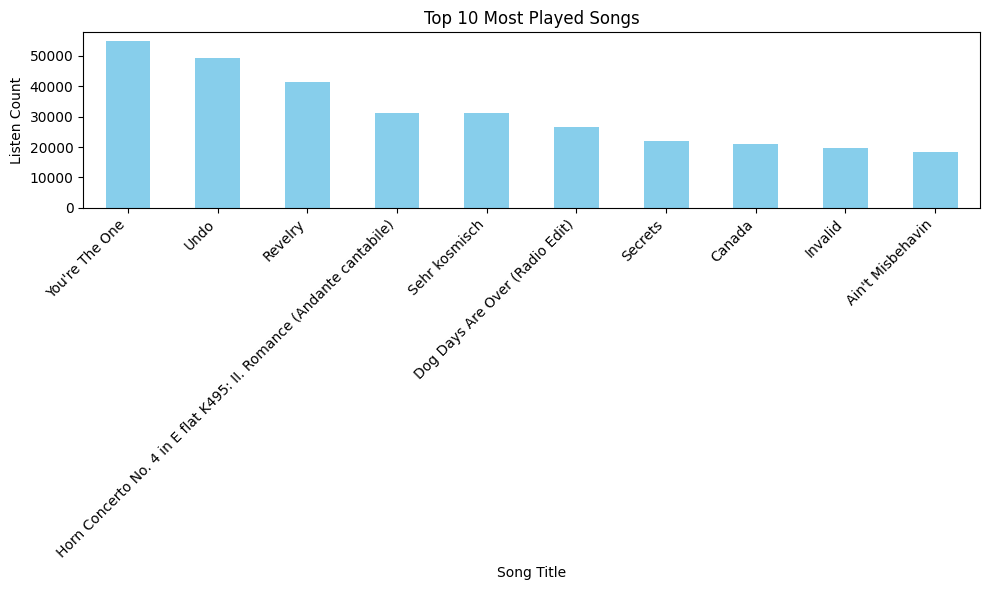

In [365]:
# Plot the top 10 songs
plot_top_songs(df)

In [366]:
def count_users_per_song(df):
    """
    Count the number of different users who listened to each song and sort the result by the number of users.

    Parameters:
        df (DataFrame): The DataFrame containing the song data.

    Returns:
        DataFrame: A DataFrame containing the song_id and the number of different users who listened to each song,
                   sorted by the number of users in descending order.
    """
    # Group the DataFrame by 'song_id' and count the number of unique 'user_id' for each song
    users_per_song = df.groupby('song_id')['user_id'].nunique().reset_index(name='num_users')

    # Sort the DataFrame by 'num_users' in descending order
    users_per_song_sorted = users_per_song.sort_values(by='num_users', ascending=False)

    return users_per_song_sorted

In [367]:
users_per_song_df = count_users_per_song(df)
print(users_per_song_df)

                 song_id  num_users
2220  SOFRQTD12A81C233C0       8277
317   SOAUWYT12A81C206F1       7032
352   SOAXGDH12A8C13F8A1       6949
614   SOBONKR12A58A7A7E0       6412
7416  SOSXLTC12AF72A7F54       6145
...                  ...        ...
8747  SOWNLZF12A58A79811         51
4492  SOLIGVL12AB017DBAE         51
622   SOBPGWB12A6D4F7EF3         50
9638  SOYYBJJ12AB017E9FD         48
2666  SOGSPGJ12A8C134FAA         48

[10000 rows x 2 columns]


We can learn that 8277 different users is the highest number of different users listened to a specific song.<br>
We can learn that 48 different users is the lowest number of different users listened to a specific song.

In [368]:
def filter_songs_by_user_count(df, max_users_list):
    """
    Filter the DataFrame to include only songs listened to by less than a specified number of users.

    Parameters:
        df (DataFrame): The DataFrame containing the song data.
        max_users_list (list): A list of maximum number of users allowed for a song.

    Returns:
        dict: A dictionary containing filtered DataFrames for each specified maximum number of users.
    """
    filtered_results = {}

    # Lists to store results for plotting
    num_less_users_list = []
    num_more_users_list = []

    for max_users in max_users_list:
        # Group the DataFrame by 'song_id' and count the number of unique users for each song
        song_listen_counts = df.groupby('song_id')['user_id'].nunique()

        # Filter out the songs with a user count greater than or equal to the specified maximum
        filtered_songs = song_listen_counts[song_listen_counts < max_users]

        # Filter the original DataFrame to include only the songs with less than the specified maximum users
        filtered_df = df[df['song_id'].isin(filtered_songs.index)]

        # Count songs with less and more than the specified maximum users
        num_less_users = len(filtered_songs)
        num_more_users = len(song_listen_counts) - num_less_users
        print(f"There are {num_less_users} songs listened to by less than {max_users} users.")
        print(f"There are {num_more_users} songs listened to by more than {max_users} users.")

        # Store the filtered DataFrame and results in the dictionary
        filtered_results[max_users] = {'filtered_df': filtered_df, 'num_less_users': num_less_users, 'num_more_users': num_more_users}

        # Append to lists for plotting
        num_less_users_list.append(num_less_users)
        num_more_users_list.append(num_more_users)

    # Plot the results
    plot_song_counts_by_max_users(max_users_list, num_less_users_list, num_more_users_list)

    return filtered_results

In [369]:
def plot_song_counts_by_max_users(max_users_list, num_less_users_list, num_more_users_list):
    """
    Plot the number of songs listened to by less and more than the specified maximum users.

    Parameters:
        max_users_list (list): List of maximum number of users.
        num_less_users_list (list): List of counts of songs listened to by less than the maximum users.
        num_more_users_list (list): List of counts of songs listened to by more than the maximum users.
    """
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar([str(max_users) for max_users in max_users_list], num_less_users_list, label='Less than')
    plt.bar([str(max_users) for max_users in max_users_list], num_more_users_list, bottom=num_less_users_list, label='More than', color="lightblue")

    # Adding labels and title
    plt.xlabel('Number of Users')
    plt.ylabel('Number of Songs')
    plt.title('Number of Songs Listened to by Less and More than the Specified Maximum Users')
    plt.legend()

    # Display the plot
    plt.show()

There are 0 songs listened to by less than 30 users.
There are 10000 songs listened to by more than 30 users.
There are 85 songs listened to by less than 60 users.
There are 9915 songs listened to by more than 60 users.
There are 2561 songs listened to by less than 90 users.
There are 7439 songs listened to by more than 90 users.
There are 4771 songs listened to by less than 120 users.
There are 5229 songs listened to by more than 120 users.
There are 6108 songs listened to by less than 150 users.
There are 3892 songs listened to by more than 150 users.
There are 7464 songs listened to by less than 200 users.
There are 2536 songs listened to by more than 200 users.


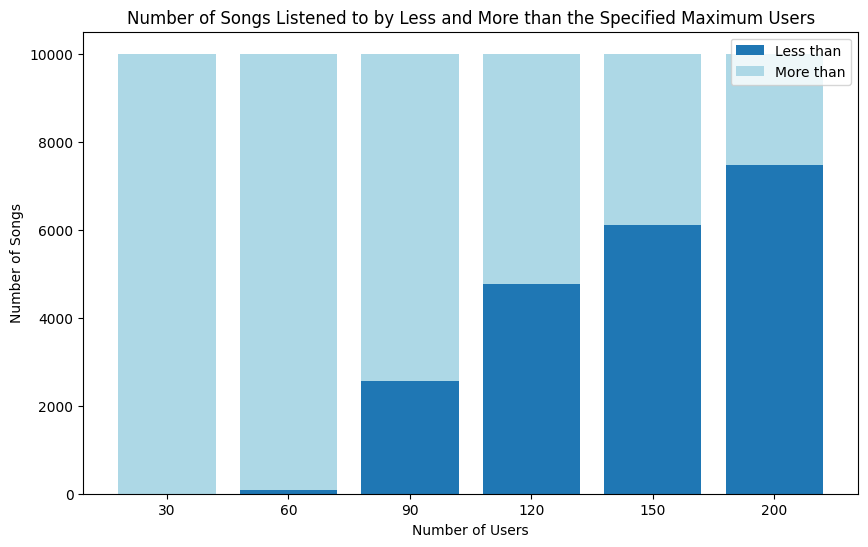

In [370]:
max_users_list = [30, 60, 90, 120, 150, 200]
filtered_results = filter_songs_by_user_count(df, max_users_list)

As we can see, all the users listened to more than 30 different songs.

It makes sense that as the number of users increases, there are fewer songs played by this increasing amount of users.

We can see that there are a lot of songs that have been heard by too few people, so it can be concluded that they are less popular, so it will be more difficult to recommend them in our recommendation system.

### Artist analysis

In [371]:
def plot_top_artists(df, n=10):
    # Calculate the total listen counts for each artist
    listen_counts = df.groupby('artist_name')['listen_count'].sum()

    # Sort the artists by listen counts in descending order
    listen_counts = listen_counts.sort_values(ascending=False)

    # Select the top n artists
    top_artists = listen_counts.head(n)

    # Printing the top artists
    print("Top", n, "Most Listened Artists:")
    print(top_artists)

    # Plotting the top artists with a horizontal bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_artists.values, y=top_artists.index, palette=sns.color_palette("Oranges_r", 10))
    plt.title('Top {} Most Listened Artists'.format(n))
    plt.xlabel('Total Listen Count')
    plt.ylabel('Artist')
    plt.tight_layout()  # Adjust layout to prevent clipping of labels

     # Adding count values next to each bar
    for i, count in enumerate(top_artists.values):
      plt.text(count, i, str(count), va='center', fontsize=10, color='black', ha='left')

    plt.show()


Top 10 Most Listened Artists:
artist_name
Coldplay                  70138
Kings Of Leon             68570
Florence + The Machine    60066
Dwight Yoakam             54136
Björk                     53814
The Black Keys            52220
Jack Johnson              44083
Justin Bieber             41645
OneRepublic               40981
Train                     39279
Name: listen_count, dtype: int64


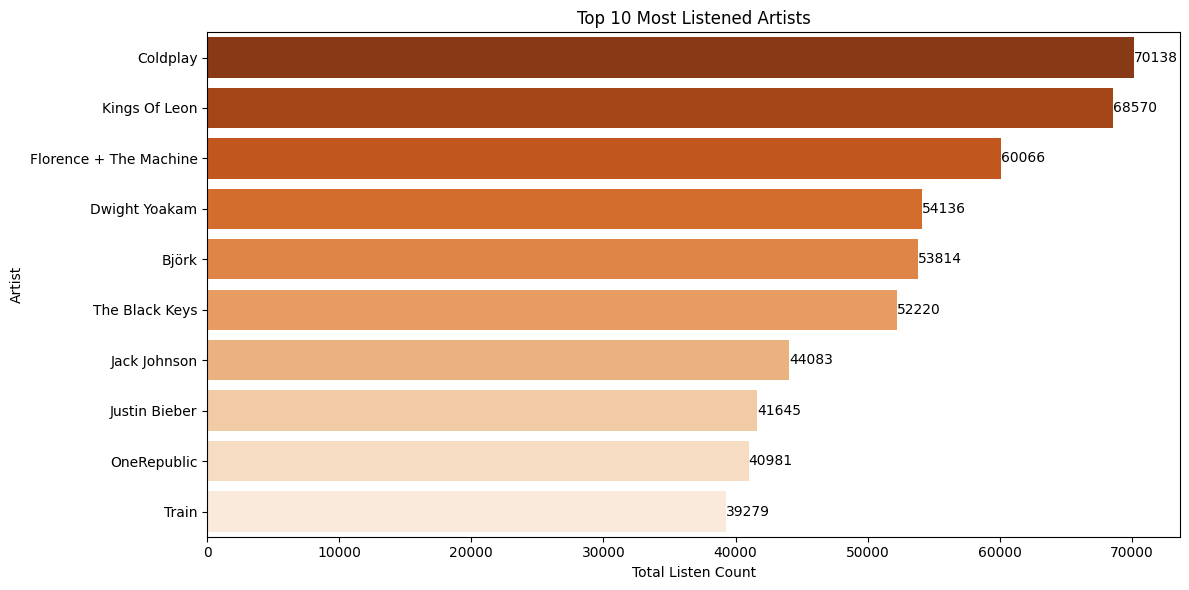

In [372]:
# Display the top 10 artists using a horizontal bar plot
plot_top_artists(df)

### Album analysis

In [373]:
def release_insights(df):
    # Calculate total listen counts per release
    total_listen_counts = df.groupby('release')['listen_count'].sum()
    # # Calculate average listen counts per release
    # avg_listen_counts = df.groupby('release')['listen_count'].mean()

    # Sort releases by total listen counts in descending order
    total_listen_counts = total_listen_counts.sort_values(ascending=False)

    # Print top releases with total listen counts
    print("Top Releases by Total Listen Counts:")
    print(total_listen_counts.head(10))

    # Plotting total listen counts
    plt.figure(figsize=(12, 6))
    sns.barplot(x=total_listen_counts.head(10).index, y=total_listen_counts.head(10).values, palette='viridis')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Release')
    plt.ylabel('Total Listen Counts')
    plt.title('Top Releases by Total Listen Counts')
    plt.tight_layout()
    plt.show()

Top Releases by Total Listen Counts:
release
If There Was A Way                  54136
Vespertine Live                     49652
Only By The Night                   46811
Greatest Hits                       45360
My Worlds                           38094
Waking Up                           33902
Now That's What I Call Music! 75    32380
Save Me_ San Francisco              31865
Mozart - Eine kleine Nachtmusik     31153
Musik von Harmonia                  31036
Name: listen_count, dtype: int64


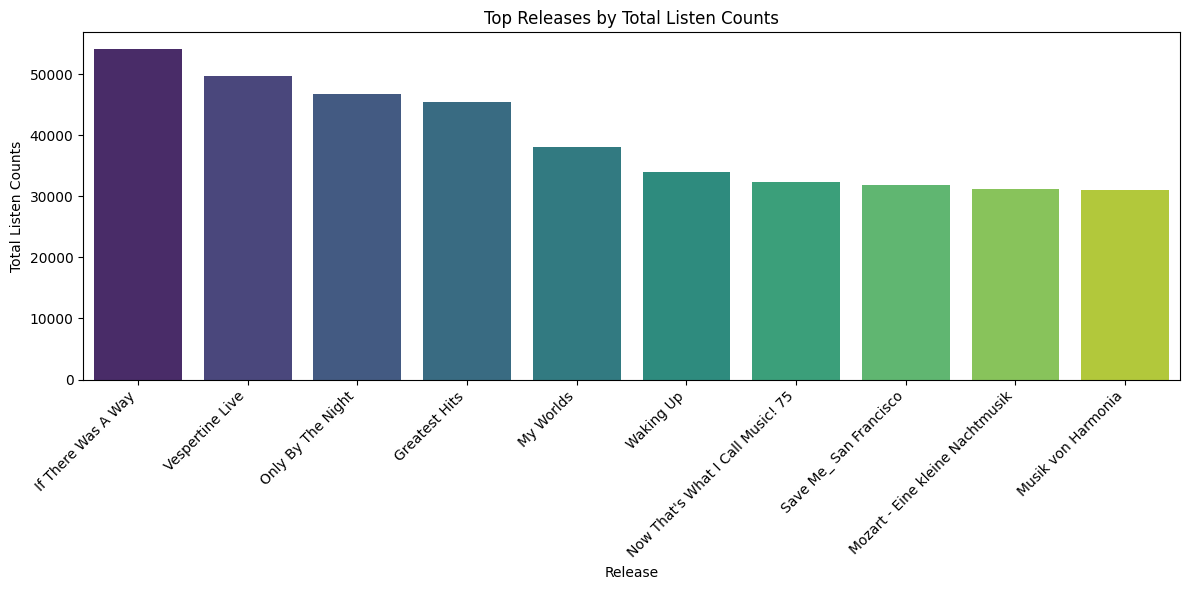

In [374]:
release_insights(df)

### Year analysis

In [375]:
# Bar Plot of Number of Unique Songs Released by Year
def plot_unique_songs_by_year(df):
    # Group the DataFrame by 'year' and count the number of unique 'song_id' for each year
    unique_songs_by_year = df.groupby('year')['song_id'].nunique().reset_index(name='num_unique_songs')

    # Print the number of unique songs released in each year
    print("Number of Unique Songs Released by Year:")
    print(unique_songs_by_year)

    # Plotting the bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='year', y='num_unique_songs', data=unique_songs_by_year, color='gold')
    plt.xticks(rotation=45)
    plt.title('Number of Unique Songs Released by Year', weight="bold", size=14)
    plt.xlabel('Year')
    plt.ylabel('Number of Unique Songs Released')
    plt.show()


Number of Unique Songs Released by Year:
    year  num_unique_songs
0      0              1773
1   1954                 1
2   1955                 1
3   1956                 2
4   1957                 1
5   1958                 6
6   1959                 6
7   1960                 5
8   1961                 3
9   1962                 7
10  1963                 6
11  1964                14
12  1965                16
13  1966                15
14  1967                23
15  1968                29
16  1969                29
17  1970                47
18  1971                22
19  1972                36
20  1973                25
21  1974                31
22  1975                22
23  1976                25
24  1977                35
25  1978                46
26  1979                37
27  1980                35
28  1981                42
29  1982                57
30  1983                51
31  1984                65
32  1985                49
33  1986                67
34  1987      

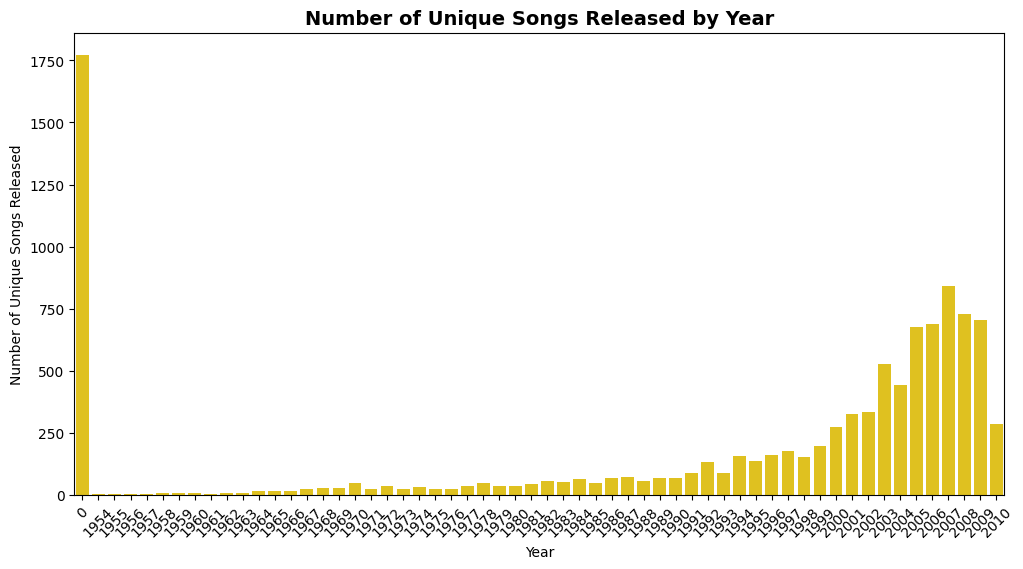

In [376]:
# Call the function to plot the number of unique songs released by year
plot_unique_songs_by_year(df)

Another check:

In [377]:
# Filter the DataFrame for songs with a release year of 0 and count the occurrences
num_songs_year_0 = df[df['year'] == 0]['song_id'].nunique()

# Print the result
print("Number of songs with a release year of 0:", num_songs_year_0)


Number of songs with a release year of 0: 1773


We can see that there are a lot of year = 0 songs, we will deal with it later.


TODO To check which timeframe the data is from?

It can be concluded that the users we have in the data listen to more contemporary songs, or alternatively, it can be concluded that as the years passed, more songs were released in each year. <br>
There is a little indent about songs released in 2004. We can think that either few songs were released this year, or our users less liked songs released this year.

In order to answer this question, let's run a correlation matrix: <br>
Because only "listen_count" and "year" features are numerical features, we will only look at those.

In order for the correlation matrix to work correctly and examine a correlation between these two features, we would like to group our data by the year the song was released.<br> In this way, we counted the number of listen counts that the songs that came out each year had.<br>
We will examine whether there is a correlation between the year the songs were released and the number of times they were listened to.<br>
In addition, we will omit year=0 because it is meaningless.

In [378]:
import matplotlib.colors as mcolors

# Define the custom colormap
colors = ['gold', 'brown']
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

def plot_correlation_matrix(df):
    # Filter out rows where year is not 0
    df_filtered = df[df['year'] != 0]

    # Group the DataFrame by 'year' and sum the 'listen_count' for each year
    yearly_listen_counts = df_filtered.groupby('year')['listen_count'].sum().reset_index()

    # Create the correlation matrix
    correlation_matrix = yearly_listen_counts.corr()

    # Plotting the correlation matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()


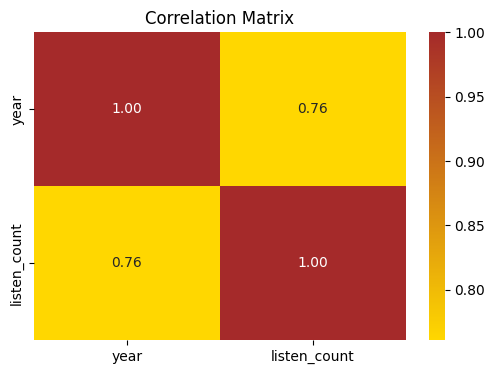

In [379]:
# Call the function to plot the correlation matrix
plot_correlation_matrix(df)

Seems pretty coordinated.<br>
We can conclude that our users like to hear more recent songs.

### Listen Count analysis

Let's look at the number of listens for a deeper understanding:

In [380]:
listen_count_df = df.groupby('listen_count')['listen_count'].count()

sorted_listen_count_df = listen_count_df.sort_values(ascending=False)

sorted_listen_count_df.head(20)

listen_count
1     1138433
2      313043
3      142933
5       93136
4       82569
6       45632
7       30920
8       22544
10      18921
9       16753
11      12531
12       9881
13       8025
15       6958
14       6476
16       5357
17       4470
18       3743
20       3309
19       3225
Name: listen_count, dtype: int64

We can see that there are 1.13 million out of 2 million plays of songs that the user has heard only once.<br>
Can we conclude that he didn't like the song and therefore never heard it again?

In [381]:
def plot_listen_count_distribution(listen_count_df, max_listen_count):
    listen_count_range = range(1, max_listen_count + 1)
    listen_count_counts = [listen_count_df.get(count, 0) for count in listen_count_range]

    plt.figure(figsize=(10, 6))
    plt.bar(listen_count_range, listen_count_counts, color='lightgreen')
    plt.title('Listen Count Distribution')
    plt.xlabel('Listen Count')
    plt.ylabel('Number of Plays')
    plt.xticks(listen_count_range, rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

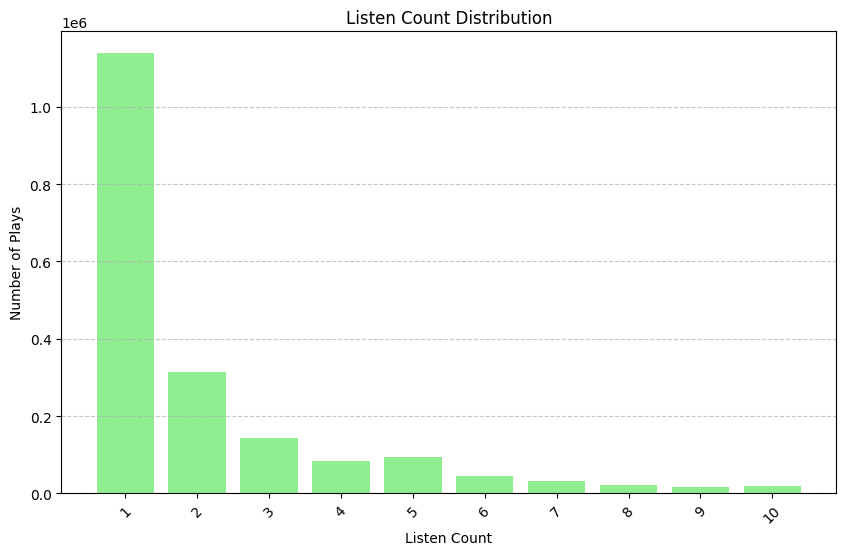

In [382]:
# Call the function to plot the distribution of listen counts within the range of 1 to max_listen_count
max_listen_count = 10  # Specify the maximum listen count
plot_listen_count_distribution(sorted_listen_count_df, max_listen_count)


In [383]:
sorted_listen_count_df.tail(100)

listen_count
221     2
162     2
232     2
181     2
215     2
       ..
270     1
260     1
259     1
255     1
2213    1
Name: listen_count, Length: 100, dtype: int64

It can be concluded that there is one special user who heard the same song 2213 times.<br>
Of course, this greatly favors this particular song.

In [384]:
# Get the index label corresponding to the maximum listen_count
max_listen_count_index = df['listen_count'].idxmax()

# Retrieve the entire row from df using the index label
row_with_max_listen_count = df.loc[max_listen_count_index]

print("Row with the largest listen count:")
print(row_with_max_listen_count)


Row with the largest listen count:
user_id         d13609d62db6df876d3cc388225478618bb7b912
song_id                               SOFCGSE12AF72A674F
listen_count                                        2213
title                                          Starshine
release                                         Gorillaz
artist_name                                     Gorillaz
year                                                2000
Name: 1228366, dtype: object


### User analysis

Now, the top 10 users listened to the most songs:

In [385]:
def get_top_active_users(df, n=10):
    return df.groupby('user_id')['listen_count'].sum().sort_values(ascending=False).head(n)

In [386]:
get_top_active_users(df)

user_id
4be305e02f4e72dad1b8ac78e630403543bab994    4426
6d625c6557df84b60d90426c0116138b617b9449    3482
d13609d62db6df876d3cc388225478618bb7b912    2686
0b19fe0fad7ca85693846f7dad047c449784647e    2679
283882c3d18ff2ad0e17124002ec02b847d06e9a    2306
083a2a59603a605275107c00812a811526c2a0af    2142
6a944bfe30ae8d6b873139e8305ae131f1607d5f    2062
5ea608df0357ec4fda191cb9316fe8e6e65e3777    2032
9c859962257112ad523f1d3c121d35191daa6d2b    2032
2231cb435771a1a621ec44e95cdd28b81fad3288    2019
Name: listen_count, dtype: int64

In [387]:
active_users = get_top_active_users(df, df['user_id'].nunique())

In [388]:
print(active_users.tail(10))

user_id
61852978edc728c089d76305b091f7dba267906f    1
fe71b720774e9b7d61a440ba733435ce74c1e758    1
66c75cd7a58ca33e891f3fe337f5b01ca8d551b2    1
89fbc18cbd68c3c2ecf9fa4785bcc718e283bf3a    1
38043f5b8555cf4ca12b1bd9e7ffa9cb20219273    1
a2ccedb6c8cab158555dc46e4cf175d841bf9f76    1
0d36fd1b02deb79387e41b33178b8dc6abdec809    1
bfd6cfaf4a0e517336cda1fe1a7bdd61231b8b7e    1
1562638492e568bb20f2d3df4efb81ae267566c3    1
8ca982d9b955055e6b24ba5e6fad49b848919400    1
Name: listen_count, dtype: int64


In [389]:
def plot_user_listen_count_distribution(active_users):
    plt.figure(figsize=(10, 6))
    plt.hist(active_users, bins=20, color='Crimson', edgecolor='black')
    plt.title('Distribution of Listen Count for Active Users')
    plt.xlabel('Total Listen Count')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

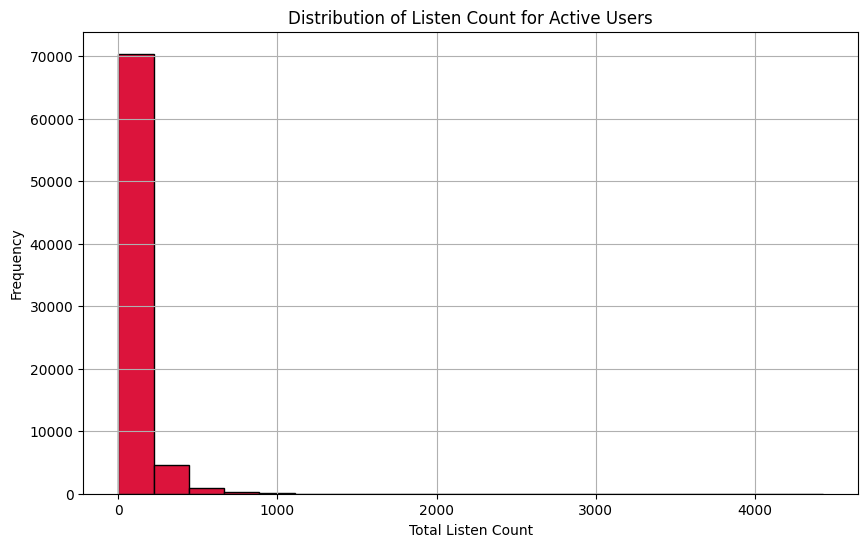

In [390]:
plot_user_listen_count_distribution(active_users)

We can see that there are a lot of users that have listened to only few songs.

It is easy to see that the first column in the output contains the most observations. We would like to refer only to users who have listened to enough songs to be part of our recommendation system.

We will ignore users who have listened to songs less or equal to 200 times.

In [391]:
filtered_users = active_users[active_users > 200]
filtered_users

user_id
4be305e02f4e72dad1b8ac78e630403543bab994    4426
6d625c6557df84b60d90426c0116138b617b9449    3482
d13609d62db6df876d3cc388225478618bb7b912    2686
0b19fe0fad7ca85693846f7dad047c449784647e    2679
283882c3d18ff2ad0e17124002ec02b847d06e9a    2306
                                            ... 
af399100a4309a29452afbe4a9f5adf2dfd73a67     201
5509cb33496db81c861128ffadecec61eaa282c4     201
e66b8411936d04dd477b0218b3d9178e6999c001     201
f5d1809812524991f107d871319cc9ef171c4a28     201
e68da5870e946b3f736ad356daa7d3eee38731a4     201
Name: listen_count, Length: 7209, dtype: int64

In [392]:
# Count the number of users who their listen count is more than 200 songs
num_users_above_200 = len(active_users[active_users > 200])
print("Number of users who their listen count is more than 200:", num_users_above_200)
num_users_below_or_equal_200 = df['user_id'].nunique() - num_users_above_200
print("Number of users who their listen count is less than or equal to 200 songs:", num_users_below_or_equal_200)

Number of users who their listen count is more than 200: 7209
Number of users who their listen count is less than or equal to 200 songs: 69144


The results we see here are not good enough. <br>
There are only 7209 users with more than 200 listens to songs.<br>
Maybe all the listen counts of a user are on only one song? Or to a very small number of songs?? Do we want to include such users in our recommendation model?

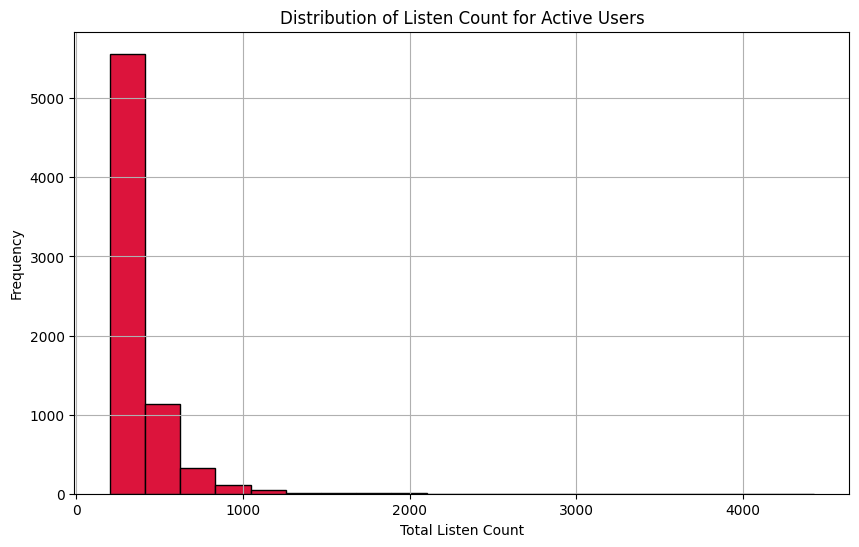

In [393]:
plot_user_listen_count_distribution(filtered_users)

In [394]:
# Count the number of users who their listen count is more than 1000 songs
num_users_above_1000 = len(active_users[active_users > 1000])
print("Number of users who their listen count is more than 1000:", num_users_above_1000)
num_users_below_or_equal_1000 = df['user_id'].nunique() - num_users_above_1000
print("Number of users who their listen count is less than or equal to 1000 songs:", num_users_below_or_equal_1000)

Number of users who their listen count is more than 1000: 102
Number of users who their listen count is less than or equal to 1000 songs: 76251


Only 102 different users has more than 1000 music listens count.

TODO Explain what we see better

Another look on the user's:

In [395]:
# Group the DataFrame by 'user_id' and count the number of songs each user listened to
user_listen_counts = df.groupby('user_id').size()

# Sort the user listen counts in descending order
sorted_user_listen_counts = user_listen_counts.sort_values(ascending=False)

# Print the sorted number of songs each user listened to
print("Number of songs each user listened to (sorted):")
print(sorted_user_listen_counts)


Number of songs each user listened to (sorted):
user_id
6d625c6557df84b60d90426c0116138b617b9449    711
fbee1c8ce1a346fa07d2ef648cec81117438b91f    643
4e11f45d732f4861772b2906f81a7d384552ad12    556
24b98f8ab023f6e7a1c37c7729c623f7b821eb95    540
1aa4fd215aadb160965110ed8a829745cde319eb    533
                                           ... 
10d3b027f494805b9223551e3db03f903953e2cf      1
87c22fcd7f5f833a8e33ba8bc5c7f4863dab5aa8      1
421be8356c6464ae9da340754c1b0b9510ae50b5      1
87a2826a059570052283d542fc03651c3a570afb      1
bec79e2e90bf0fe7238385b2ae6af711dd6c6d1d      1
Length: 76353, dtype: int64


We can learn that the user who listened to the most different songs listened to 711 songs.

In [396]:
def filter_users(df, min_listen_counts=[30, 60, 90, 120, 150]):
    results = {}
    for min_listen_count in min_listen_counts:
        # Group by 'user_id' and count the number of rows for each user
        user_listen_counts = df.groupby('user_id').size()

        # Filter users based on the minimum listen count
        filtered_users = user_listen_counts[user_listen_counts >= min_listen_count]

        # Get the DataFrame containing only the observations for the filtered users
        filtered_df = df[df['user_id'].isin(filtered_users.index)]

        # Get the user IDs of the filtered users
        filtered_user_ids = filtered_users.index

        # Count the number of users who meet the criterion
        num_filtered_users = len(filtered_user_ids)

        # Count the number of users who did not meet the criterion
        num_non_filtered_users = len(user_listen_counts) - num_filtered_users

        # Store the results
        results[min_listen_count] = {'filtered_df': filtered_df, 'num_filtered_users': num_filtered_users, 'num_non_filtered_users': num_non_filtered_users}

    return results

In [397]:
# Filter out users who have listened to more than 30, 60, 90, 120, and 150 songs respectively and get the counts
filtered_results = filter_users(df, min_listen_counts=[30, 60, 90, 120, 150])

# Print the results for each minimum listen count
for min_listen_count, result in filtered_results.items():
    print(f"\nResults for minimum song count of {min_listen_count}:")
    print("Filtered DataFrame:")
    result['filtered_df']
    print("Number of users who have listened to more than", min_listen_count, "songs:", result['num_filtered_users'])
    print("Number of users who have listened to less than or equal to", min_listen_count, "songs:", result['num_non_filtered_users'])



Results for minimum song count of 30:
Filtered DataFrame:
Number of users who have listened to more than 30 songs: 20391
Number of users who have listened to less than or equal to 30 songs: 55962

Results for minimum song count of 60:
Filtered DataFrame:
Number of users who have listened to more than 60 songs: 7298
Number of users who have listened to less than or equal to 60 songs: 69055

Results for minimum song count of 90:
Filtered DataFrame:
Number of users who have listened to more than 90 songs: 3156
Number of users who have listened to less than or equal to 90 songs: 73197

Results for minimum song count of 120:
Filtered DataFrame:
Number of users who have listened to more than 120 songs: 1583
Number of users who have listened to less than or equal to 120 songs: 74770

Results for minimum song count of 150:
Filtered DataFrame:
Number of users who have listened to more than 150 songs: 875
Number of users who have listened to less than or equal to 150 songs: 75478


In [398]:
def plot_filtered_results(filtered_results):
    min_listen_counts = sorted(filtered_results.keys())
    num_filtered_users_list = []
    num_non_filtered_users_list = []

    for min_listen_count in min_listen_counts:
        result = filtered_results[min_listen_count]
        num_filtered_users_list.append(result['num_filtered_users'])
        num_non_filtered_users_list.append(result['num_non_filtered_users'])

    # Plotting the results
    bar_width = 0.35
    index = range(len(min_listen_counts))

    plt.figure(figsize=(12, 6))
    plt.bar([i + bar_width for i in index], num_filtered_users_list, bar_width, label='More than', color="Crimson")
    plt.bar(index, num_non_filtered_users_list, bar_width, label='Less than or equal to', color="lightgrey")

    plt.xlabel('Minimum Different Songs Count Per User')
    plt.ylabel('Number of Users')
    plt.title('Number of Users by Minimum Different Songs Count')
    plt.xticks([i + bar_width / 2 for i in index], min_listen_counts)
    plt.legend()
    plt.tight_layout()
    plt.show()

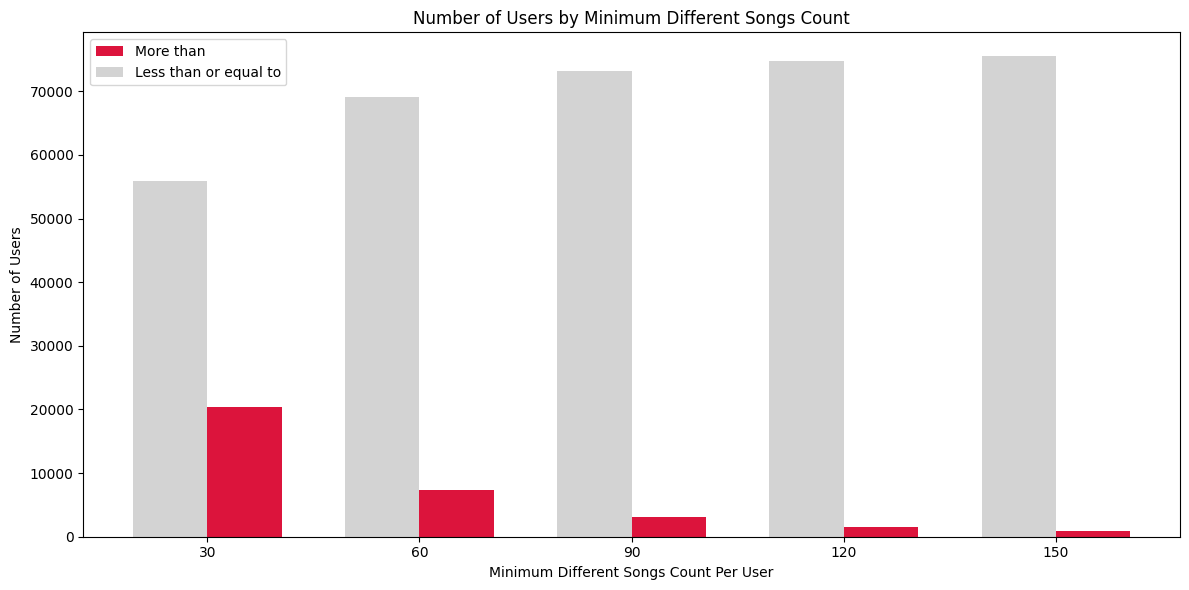

In [399]:
# Plot the filtered results
plot_filtered_results(filtered_results)

### Rating analysis

Generate a rating scale:

In order to create a rating system, we will want our data to be restricted to users that have listened to every song at most 'n' times. In this way, listen_count can be used as a rating system, with values between 1 and n. <br>
(there is no 0 rating, our data is users listening to songs, there is no song played less than one time).

Let's take a look on the relevant data:

In [400]:
def filter_users_by_max_listen_count(df, start_count=3, end_count=10):
    max_listen_counts = range(start_count, end_count + 1)
    ratings = {}

    for max_listen_count in max_listen_counts:
        # Group the data by 'user_id' and calculate the maximum listen count for each user
        max_listen_counts = df.groupby('user_id')['listen_count'].max()

        # Filter out the users whose maximum listen count is greater than the specified maximum listen count
        relevant_users = max_listen_counts[max_listen_counts <= max_listen_count]

        # Filter the original DataFrame to include only the relevant users
        filtered_df = df[df['user_id'].isin(relevant_users.index)]

        # Count the number of users left after filtering
        num_users_left = len(relevant_users)

        ratings[max_listen_count] = num_users_left
        print(f"Number of users left for max listen count of {max_listen_count}: {num_users_left}")

    return filtered_df, ratings

def plot_users_left(ratings):
    plt.figure(figsize=(10, 6))
    plt.bar(ratings.keys(), ratings.values(), color='purple')
    plt.title('Number of Users Left vs Maximum Listen Count')
    plt.xlabel('Maximum Listen Count')
    plt.ylabel('Number of Users Left')
    plt.xticks(list(ratings.keys()))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Number of users left for max listen count of 3: 20141
Number of users left for max listen count of 4: 24679
Number of users left for max listen count of 5: 31796
Number of users left for max listen count of 6: 36293
Number of users left for max listen count of 7: 39635
Number of users left for max listen count of 8: 42397
Number of users left for max listen count of 9: 44636
Number of users left for max listen count of 10: 48156


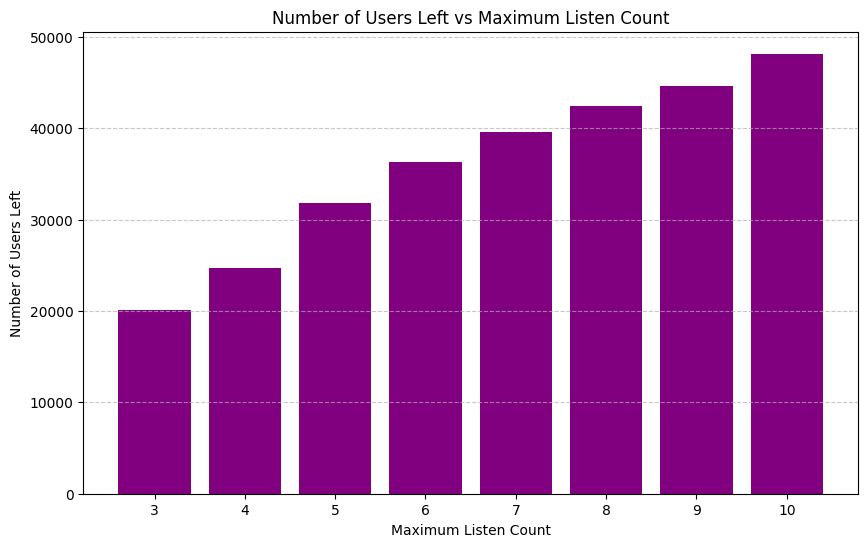

In [401]:
# Call the function to check max listen counts from 3 to 10
filtered_df, ratings = filter_users_by_max_listen_count(df, start_count=3, end_count=10)

# Plot the results
plot_users_left(ratings)

Seems that when there is a rating scale from 1-5, we left with almost half of the data and with 31796 relevant users - enough data to work with.<br>
We will deal with all of that later..

In [402]:
def plot_listen_counts_range(df, start_count=3, end_count=8):
    for max_listen_counts in range(start_count, end_count + 1):
        # Group the DataFrame by 'user_id' and calculate the maximum listen count for each user
        max_listen_counts_users = df.groupby('user_id')['listen_count'].max()

        # Filter out users who have listened to a song more than the specified maximum listen count
        relevant_users = max_listen_counts_users[max_listen_counts_users <= max_listen_counts].index

        # Filter the original DataFrame to include only the relevant users
        filtered_df = df[df['user_id'].isin(relevant_users)]

        # Count the occurrences of each listen count
        listen_count_counts = filtered_df['listen_count'].value_counts().sort_index()

        # Plot the results
        plt.figure(figsize=(10, 6))
        plt.bar(listen_count_counts.index, listen_count_counts.values, color='purple')
        plt.title(f'Number of Listen Counts (1-{max_listen_counts})')
        plt.xlabel('Listen Count')
        plt.ylabel('Frequency')
        plt.xticks(listen_count_counts.index)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

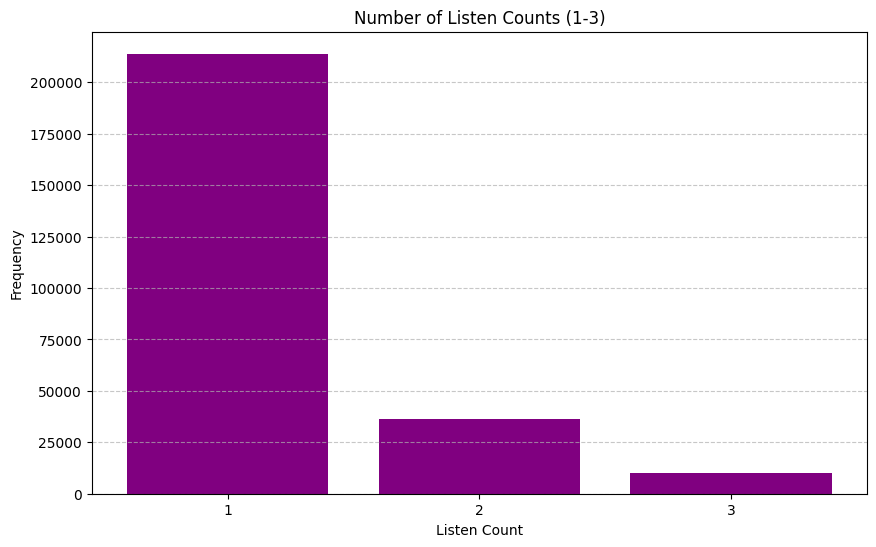

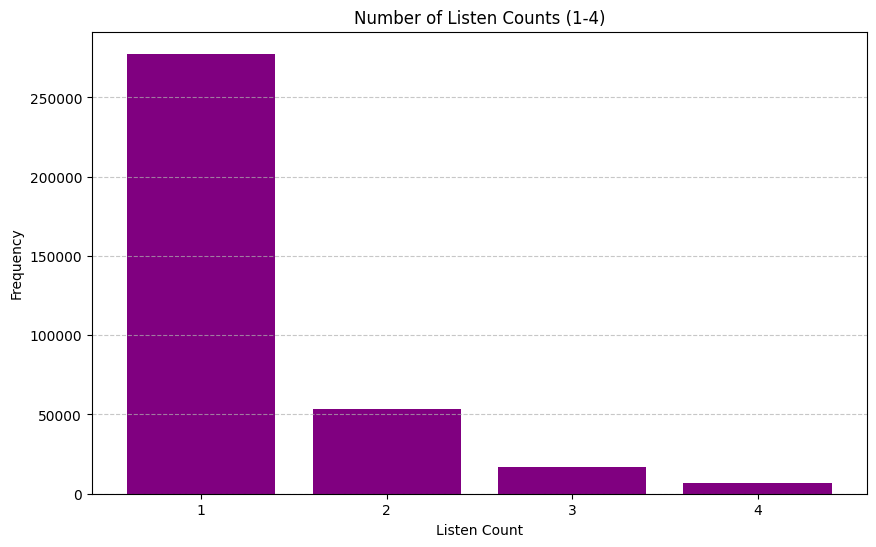

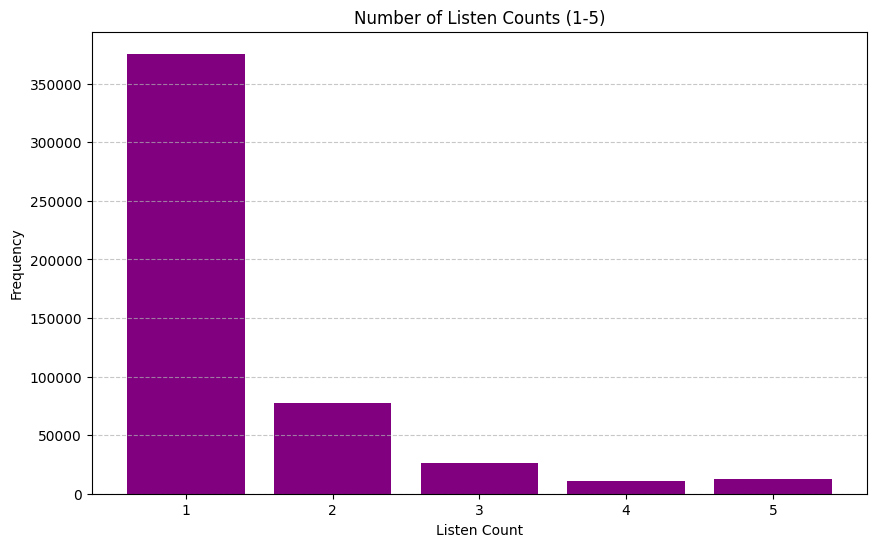

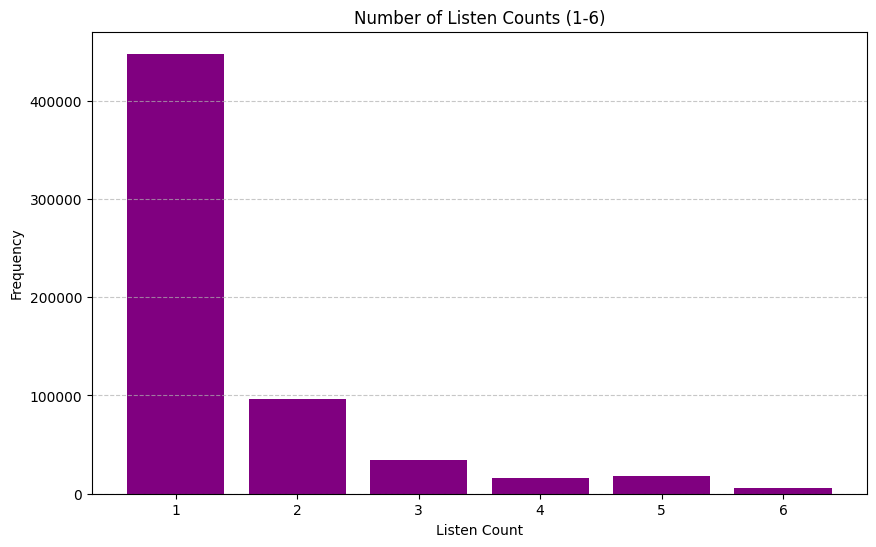

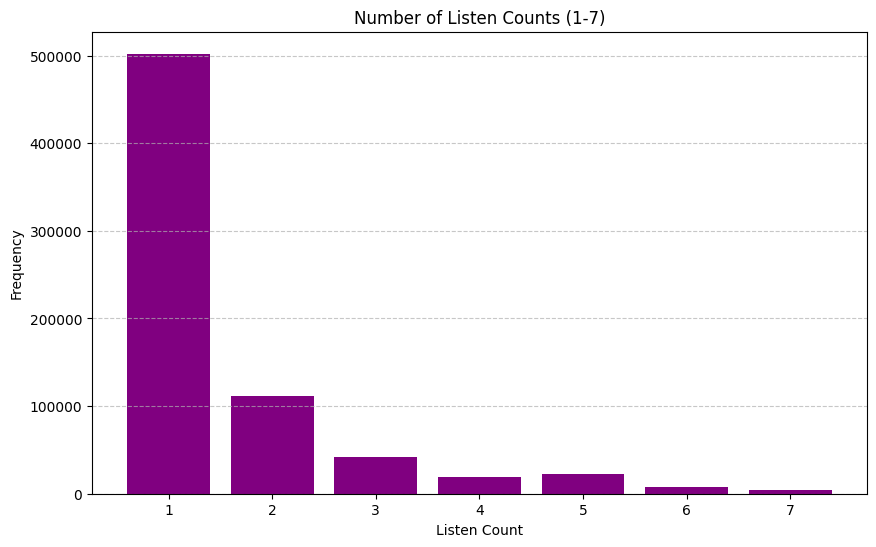

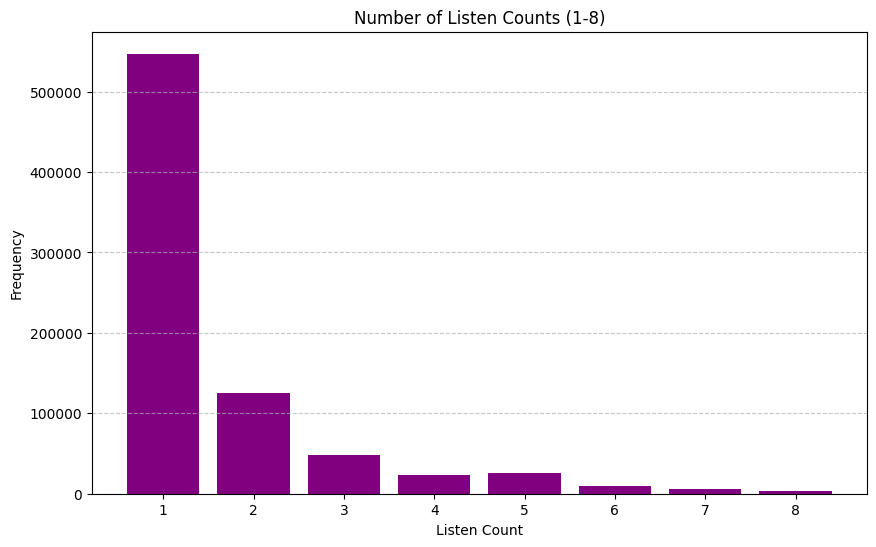

In [403]:
# Call the function with start_count=3 and end_count=8
plot_listen_counts_range(df, start_count=3, end_count=8)

# Preprocessing

In [ ]:
# Apply a label-encoding for user_id and song_id attributes.
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
combined_df['user_id'] = label_encoder.fit_transform(combined_df['user_id'])
combined_df['song_id'] = label_encoder.fit_transform(combined_df['song_id'])

In [ ]:
combined_df

,user_id,song_id,listen_count,title,release,artist_name,year
0,54961,153,1,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,413,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,736,1,Stronger,Graduation,Kanye West,2007
3,54961,750,1,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,1188,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
...,...,...,...,...,...,...,...
1999995,64590,3660,2,Ignorance (Album Version),Ignorance,Paramore,0
1999996,64590,3736,4,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009
1999997,64590,3744,3,What I've Done (Album Version),What I've Done,Linkin Park,2007
1999998,64590,3893,1,Up,My Worlds,Justin Bieber,2010


We decided after deep research to filter the data we have according to 2 main criteria: We would not like to include in the data:
1. Users who have listened to less than 90 different songs
2. Songs that have been listened to by less than 120 different users

The question arises is how to do it:<br>
a. First get rid of the users who do not meet the criteria we defined to get rid from the songs after that.<br>
b. or alternatively, first get rid of the songs that do not meet the criteria.

We first thought of getting rid of the songs that weren't played by enough users and only then getting rid of the users who didn't listen to enough songs,
So the songs we omitted will be omitted from the users who heard them.

We have identified a problem, we would like to judge each user by all the songs he heard and not just by some of them. Diluting the songs first will hurt users who met the criteria but are now disqualified because songs they heard were already omitted from the data. For the reliability and correctness of our recommendation system, we would like to include users in the system even if the songs they hear are special songs.

It would be more correct to first dilute the users who have not listened to enough songs, to ensure that the recommendation system only learns from sufficiently active users. After that, we'll thin out the songs that haven't been played by enough different users.

In conclusion, we chose option a.

In [ ]:
# Group data on user_id, and count how many different songs each user has listened to.
group_users = combined_df.groupby('user_id').count().reset_index(names=['user_id'])
# Drop the users that have listened to less than 90 songs.
combined_df = combined_df.loc[~combined_df['user_id'].isin(group_users[group_users['listen_count'] < 90]['user_id'])]

In [ ]:
# Group data on song_id, and count how many different users listened to each song.
group_songs = combined_df.groupby('song_id').count().reset_index(names=['song_id'])
# Drop the songs that have been listened to by less than 120 users.
combined_df = combined_df.loc[~combined_df['song_id'].isin(group_songs[group_songs['listen_count'] < 120]['song_id'])]

In [ ]:
# Drop records with play_count more than(>) 5
combined_df = combined_df[combined_df.listen_count <= 5]

In [ ]:
# Dropping all the records that have the `year = 0`.
df_final = combined_df[combined_df['year'] > 0]

TODO Fix df

In [ ]:
df_final.reset_index(inplace=True)

In [ ]:
df_final

,index,user_id,song_id,listen_count,title,release,artist_name,year
0,200,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000
1,202,6958,512,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004
2,203,6958,549,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007
3,204,6958,703,1,They Might Follow You,Tiny Vipers,Tiny Vipers,2007
4,205,6958,719,1,Monkey Man,You Know I'm No Good,Amy Winehouse,2007
...,...,...,...,...,...,...,...,...
97222,1999731,47786,9081,2,Take Me Out,Take Me Out,Franz Ferdinand,2003
97223,1999736,47786,9186,1,Bitter Sweet Symphony,Bitter Sweet Symphony,The Verve,1997
97224,1999745,47786,9351,2,The Police And The Private,Live It Out,Metric,2005
97225,1999755,47786,9543,1,Just Friends,Back To Black,Amy Winehouse,2006


# Full function section


TODO - this section we be redone!!!!!

https://github.com/rctruta/music_recommendation_system/blob/main/music_recommendation_system_final_submission.ipynb

In [ ]:
# ========== Function precision_recall_at_k ==========
def precision_recall_at_k(model, k=10, threshold=1, verbose=True):
    """
    A function to calculate rmse, precision, recall, and F1_score, at k.
    This function is adapted from the one in the Surprise library.
    Params:
      model: the model to be used for predictions
      k: the number of relevant items to be considered (top k)
      threshold: the minimum value that a rating should satisfy to be relevant
      verbose: Bool, determines the way to display the results
    Returns:
      [rmse, recall, precision, f1_score]
        verbose=True: displays the list containing the 4 metrics
        verbose=False: returns a list with the 4 metrics.
          This is useful when experimenting with various values for (k, threshold).

    """

    # First map the predictions to each user.
    user_est_true = defaultdict(list)

    # Making predictions on the test data.
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user play counts by estimated value.
        user_ratings.sort(key=lambda x : x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[ : k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[ : k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Here, we set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Here, we set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    rmse = round(accuracy.rmse(predictions, verbose=False), 3)

    f1_score = round((2 * precision * recall) / (precision + recall), 3)

    if verbose:
        return print(clr.S+'rmse: {}, recall: {}, precision: {}, f1_score: {}'.format(rmse, recall, precision, f1_score)+clr.E)
    else:
        return [rmse, recall, precision, f1_score]

# ========== Function get_songs_played_by_user ==========
def get_songs_played_by_user(user, data):
    """
    Returns all the songs played by a user.
    Params:
        user: user_id
        data: the dataframe with the data
    Returns:
        An array with all the song_ids of the songs user_id listened to.
    TODO: it can be easily updated to generalize the interaction between a user and items.
    Add an additional param item='song_id', and change the return condition.
    """
    return data[data['user_id'] == user]['song_id'].unique()

# ========== Function get_songs_not_played_by_user ==========
def get_songs_not_played_by_user(user, data):
    """
    Returns all the songs not played by a user.
    Params:
        user: user_id
        data: the dataframe with the data
    Returns:
        An array with all the song_ids of the songs user_id had not listened to.
    TODO: it can be easily updated to generalize the interaction between a user and items.
    Add an additional param item='song_id', and change the return condition.
    """
    return data[~data['song_id'].isin(get_songs_played_by_user(user))]['song_id'].unique()

# ========== Function played_count_predict ==========
def play_count_predict(algo, user, song, r_ui=None):
    """
    A function that uses algo, to predict the rating for a song, by user.
    Args:
        algo: the algorithm used for prediction
        user: the user_id
        song: the song_id
        r_ui: play_count, if it exists
    Returns:
        A formatted display of the results of the prediction method.
    """

    r_ui = algo.predict(user, song, r_ui=r_ui).r_ui
    est = round(algo.predict(user, song).est, 2)
    return print(clr.S+'Displaying the predictions for user {} and song {}.\n\n- Real prediction: {},\n- Estimated prediction: {}.'
                 .format(user, song, r_ui, est)+clr.E)

# ========== Function display_best_params ==========
def display_best_params(model):
    """
    Function to display the best RMSE and values of the hyper-parameters, following a Grid/Randomized search.
    Args:
        model: the model used
    Returns:
    """
    print(clr.S+'RMSE of the best option: {}'.format(round(model.best_score['rmse'], 3))+clr.E)
    print(clr.S+'The hyperparameters of the best option: {}'.format(model.best_params['rmse'])+clr.E)

# ========== Function get_recommendations ==========
def get_recommendations(data, user, n, algo):
    """
    Function to get the top_n recommendations for a user.
    Params:
        data: the DataFrame with user-item information
        user: the ID of the user for which we generate recommendations
        n: the upper limit of the recommendations we are making
        algo: the algorithm used for recommendations
    Returns:
        A list of the top_n items recommended to the user.
    """
    # Creating an empty list to store the recommended song IDs.
    recommendations = []

    # Creating an user-item interactions matrix.
    user_item_interactions_matrix = data.pivot(index='user_id', columns='song_id', values='play_count')

    # Extracting those song IDs that the user_id has not listened to yet.
    non_listened_songs = user_item_interactions_matrix.loc[user][user_item_interactions_matrix.loc[user].isnull()].index.tolist()

    # Looping through each of the song IDs that user_id has not listened to yet.
    for item_id in non_listened_songs:

        # Predicting the play_count for those songs not listened to by this user.
        est = round(algo.predict(user, item_id).est, 2)

        # Appending the predicted play_counts.
        recommendations.append((item_id, est))

    # Sorting the predicted play_counts in descending order.
    recommendations.sort(key = lambda x: x[1], reverse=True)

    # Returing top n highest predicted play_counts for this user.
    return recommendations[:n]

# ========== Function get_users_who_played_song ==========
def get_users_who_played_song(song, data):
    """
    data=df_final
    Returns all the users who listened to the song.
    Params:
        song: song_id
        data: the dataframe with the data
    Returns:
        An array with all the user_ids of the users who listened to the song.
    TODO: it can be easily updated to generalize the interaction between a user and items.
    Add an additional param item='user_id', and change the return condition.
    """
    return data[data['song_id'] == song]['user_id'].unique()

# ========== Function get_users_who_did_not_played_song ==========
def get_users_who_did_not_played_song(song, data):
    """
    Returns all the users who did not listened to the song.
    Params:
        song: song_id
        data: the dataframe with the data
    Returns:
        An array with all the user_ids of the users who had not listened to the song.
    TODO: it can be easily updated to generalize the interaction between a user and items.
    Add an additional param item='user_id', and change the return condition.
    """
    return data[~data['user_id'].isin(get_users_who_played_song(song, data=data))]['user_id'].unique()

# ========== Function ==========

## Splitting the data

# Recommendation system workflow

https://github.com/rctruta/music_recommendation_system/blob/main/music_recommendation_system_final_submission.ipynb

# Algorithms and Models analysis

We will use a few diffrent approach, trying a few models for Recoomendation System and then will compare between them.
 The models we will use :    
 1. Rank - Based (Popularity) Model  
 2.  

https://github.com/rctruta/music_recommendation_system/blob/main/music_recommendation_system_final_submission.ipynb

## Rank-based (Popularity)

In this model, songs that are frequently listened to or have high listen counts are ranked higher and recommended to users.

This model does not take into account the individual preferences or tastes of users. Instead, it focuses on recommending songs that are popular among a large group of users.


In [ ]:
# Calculating the average of listen_count :
avg_count = df_final.groupby('song_id')['listen_count'].mean()
# Calculating the frequency each song was listened
sum_count = df_final.groupby('song_id')['listen_count'].sum()

In [ ]:
# Creating dataframe with : avg_count and sum_count
rb_popular = pd.DataFrame({'avg_count': avg_count,'sum_count': sum_count})
# Descending order, by the average counts a song was listened.
rb_popular = rb_popular.sort_values(by='avg_count', ascending=False)
# Let us see the first five records of the rb_popular dataset
rb_popular.head()

,avg_count,sum_count
song_id,,
7224,3.373832,361
8324,2.625000,252
9942,2.486667,373
5531,2.309061,1427
5653,2.296296,248


In [ ]:
rb_popular.describe(include='all')

,avg_count,sum_count
count,478.000000,478.000000
mean,1.638275,341.083682
std,0.210920,218.353466
min,1.238710,155.000000
25%,1.486484,205.250000
50%,1.613600,248.500000
75%,1.744960,389.750000
max,3.373832,1463.000000


Let's define a function that findss the top n songs for a recommendation based on their average listen counts. <br> Additionally, we'll include a threshold for the minimum number of listen counts a song must have to be considered for recommendation.

In [ ]:
# Creating a function that finds the top n songs based on their highest average listen count and minimum interactions.
# Find the top *n* songs that have _at least_ *min_interaction*s (>= min_interaction).
# We set the default value for min_interaction to be 200, which is > min(listen_freq).- TODO to change ti the right variable

def top_n_songs(rb_popular, n, min_interaction=200):

    # Finding songs with minimum number of interactions
    recommendations = rb_popular[rb_popular['sum_count'] >= min_interaction]

    # Sorting songs based by their average listen_count
    recommendations = recommendations.sort_values(by='avg_count', ascending=False)

    # Return the top n songs
    return recommendations.index[:n]

In [ ]:
# Recommending the 'TOP 10 SONGS' using the function defined above

list(top_n_songs(rb_popular, 10))

rb_popular.loc[top_n_songs(rb_popular, 10)]

,avg_count,sum_count
song_id,,
7224,3.373832,361
8324,2.625000,252
9942,2.486667,373
5531,2.309061,1427
5653,2.296296,248
8483,2.235772,275
657,2.218543,335
614,2.217158,827
4831,2.206186,214


In [ ]:
# Check if 'song_id' is already the index and if not - Reset the index so that song_id becomes the index
if 'song_id' in df_final.columns:
    # Reset the index so that song_id becomes the index
    df_final.set_index('song_id', inplace=True)

# Find the indices of the top 10 songs
top_n_song_indices = top_n_songs(rb_popular, 10)

# Get the rows corresponding to the top 10 songs from df_final and drop duplicate songs
top_n_songs_df = df_final.loc[top_n_song_indices].drop_duplicates(subset=['title'])

# Print the top 10 unique songs with all their information except 'user_id' and listen_count
top_n_songs_df[['title', 'release', 'artist_name', 'year']]



,title,release,artist_name,year
song_id,,,,
7224,Victoria (LP Version),Hit By A Train: The Best Of Old 97's,Old 97's,2006
8324,The Big Gundown,Invaders Must Die Remixes and Bonus Tracks,The Prodigy,2009
9942,Greece 2000,Greece 2000,Three Drives,1997
5531,Secrets,Waking Up,OneRepublic,2009
5653,Transparency,Workout Holiday,White Denim,2008
8483,Video Killed The Radio Star,Friends Reunited: Music Of The Year 1979,The Buggles,1979
657,Luvstruck,Hard House Anthems,Southside Spinners,1999
614,You're The One,If There Was A Way,Dwight Yoakam,1990
4831,Heaven Must Be Missing An Angel,Capitol Gold: The Best Of Tavares,Tavares,1979


In [ ]:
# Merge the two DataFrames on 'rb_popular'
top_10_info = pd.merge(top_n_songs_df[['title', 'release', 'artist_name', 'year']], rb_popular.loc[top_n_songs(rb_popular, 10)], left_index=True, right_index=True)

# Display the combined information
top_10_info


,title,release,artist_name,year,avg_count,sum_count
song_id,,,,,,
7224,Victoria (LP Version),Hit By A Train: The Best Of Old 97's,Old 97's,2006,3.373832,361
8324,The Big Gundown,Invaders Must Die Remixes and Bonus Tracks,The Prodigy,2009,2.625000,252
9942,Greece 2000,Greece 2000,Three Drives,1997,2.486667,373
5531,Secrets,Waking Up,OneRepublic,2009,2.309061,1427
5653,Transparency,Workout Holiday,White Denim,2008,2.296296,248
8483,Video Killed The Radio Star,Friends Reunited: Music Of The Year 1979,The Buggles,1979,2.235772,275
657,Luvstruck,Hard House Anthems,Southside Spinners,1999,2.218543,335
614,You're The One,If There Was A Way,Dwight Yoakam,1990,2.217158,827
4831,Heaven Must Be Missing An Angel,Capitol Gold: The Best Of Tavares,Tavares,1979,2.206186,214


Seems like there is a mix of different release years, and popularity levels among the songs. <br> For example, "Victoria (LP Version)" by Old 97's is from 2006 and has an average listen count of 3.37, indicating it is quite popular. <br> And "Heaven Must Be Missing An Angel" by Tavares is from 1979 with a lower average listen count of 2.21, showing that older songs can still be popular among listeners. <br> This suggests that music preferences are diverse and not solely based on release year or genre.

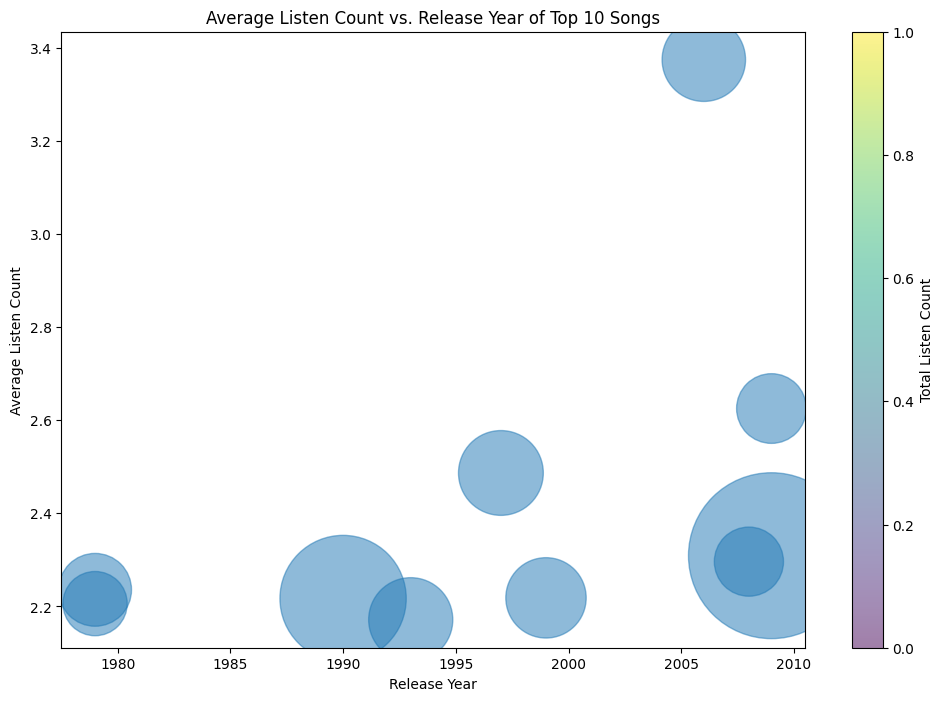

In [ ]:
# Plotting the TOP 10 SONGS

# X-axis (Release Year): Each point on the x-axis represents the release year of a song.

# Y-axis (Average Listen Count): The y-axis shows the average listen count for each song.

# Point Size: The size of each point is determined by the total listen count of the song.
# Larger points indicate songs that have been listened to more frequently.

# Color: The color of each point also represents the total listen count,
# with darker colors indicating songs with higher total listen counts.

plt.figure(figsize=(12, 8))
plt.scatter(top_10_info['year'], top_10_info['avg_count'], s=top_10_info['sum_count']*10, alpha=0.5, cmap='viridis')
plt.title('Average Listen Count vs. Release Year of Top 10 Songs')
plt.xlabel('Release Year')
plt.ylabel('Average Listen Count')
plt.colorbar(label='Total Listen Count')
plt.show()


# Importing RecSys algos
TODO: maybe put in the beginning

In [ ]:
# Install the surprise package using pip. Uncomment and run the below code to do the same

!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162732 sha256=4d79daf238ccefd32f48ef83e3e2f2253130e183e6360a7ef771b1e6bbf8e66a
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
# Import the necessary libraries

# To compute the accuracy of models
from surprise import accuracy

# This class is used to parse a file containing play_counts, data should be in structure - user; item; play_count
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV, RandomizedSearchCV

# For splitting the data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing KFold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

## Useful functions

1. **precision_recall_at_k**: This is a common metrics that help evaluate the performance of recommender and ranking systems by RMSE, precision@k, recall@k, and F_1 score.
* k - represents the number of top recommended songs to consider when evaluating the precision and recall metrics. It determines how many of the top-ranked songs are assessed for their relevance to the user's preferences. (we will choose default of top 10).
* threshold - represents the minimum rating (user's listen count) that qualifies it as relevant. It helps distinguish between songs that meet the user's preferences and those that do not. (we will choose default of 1).
* RMSE - Root Mean Squared Error measures the average difference between predicted and actual ratings.
* precision@k - Precision at k measures the proportion of relevant items among the top k recommendations.<br>
  * Precision@k = Number of relevant items recommended in top k / k
* recall@k - Recall at k measures the proportion of relevant items captured within the top k recommendations. <br>
  * Recall@k = Number of relevant items recommended in top k / Total number of relevant items
* F_1 score - The harmonic mean of precision and recall, providing a balanced measure of the system's performance. <br>
  * F1 = (2×Precision×Recall) / (Precision+Recall)
* Output - The function provides a comprehensive evaluation of the system's effectiveness through these metrics.<br><br>
* "Relevant items" refer to items that are considered valuable or appropriate for a particular user. Here, it could be songs that the user has rated highly or listened to frequently.

In [ ]:
# The function to calulate the RMSE, precision@k, recall@k, and F_1 score
def precision_recall_at_k(testset, model, k = 10, threshold = 1):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions=model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x : x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[ : k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[ : k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    # Command to print the overall precision
    print('Precision: ', precision)

    # Command to print the overall recall
    print('Recall: ', recall)

    # Formula to compute the F-1 score
    print('F_1 score: ', round((2 * precision * recall) / (precision + recall), 3))

2. **listen_count_predict:**
* This function uses the model to predict the rating (listen_count) for a song, by user.
* r_ui stands for "rating user-item" and is used to evaluate the performance of recommendation algorithms by comparing predicted ratings to actual ratings (it will be the listen_count, if exists)
* This function returns a formatted display of the results of the prediction method.

In [ ]:
def listen_count_predict(model, user_id, song_id, r_ui=None):
    r_ui = model.predict(user_id, song_id, r_ui=r_ui).r_ui
    est = round(model.predict(user_id, song_id).est, 2)
    return print(clr.S+'The predictions for user {} and song {} is:\n\n- Real prediction: {},\n- Estimated prediction: {}.'
                 .format(user_id, song_id, r_ui, est)+clr.E)

3.  **get_songs_played_by_user**:
* This function returns all the songs played by or not played by a user.
* played is boolean indicating whether to return songs played by the user (True) or not played (False).
*  This function returns an array with all the song_ids of the songs user_id listened to or did not listen to.

In [ ]:
def get_songs_played_by_user(user_id, data, played=True):
    if played:
        songs = data[data['user_id'] == user_id]['song_id'].unique()
        print("Songs played by user {}:".format(user_id))
    else:
        songs = data[~data['song_id'].isin(get_songs_played_by_user(user_id, data))]['song_id'].unique()
        print("Songs not played by user {}:".format(user_id))
    return songs

4. **get_users_who_played_or_not_song**:
* This function returns all the users who played or did not play a song.
* played is boolean indicating whether to return users who played the song (True) or did not play (False).
*  This function returns an array with all the user_ids of the users who listened to or did not listen to the song.

In [ ]:
def get_users_who_played_or_not_song(song_id, data, played=True):
    if played:
        users = data[data['song_id'] == song_id]['user_id'].unique()
        print(clr.S + "Users who played song {}:".format(song_id) + clr.E)
    else:
        users = data[~data['user_id'].isin(get_users_who_played_song(song_id, data=data))]['user_id'].unique()
        print(clr.S + "Users who did not play song {}:".format(song_id) + clr.E)
    return users

5. **get_recommendations**:
* This function generates recommendations for a given user based on their interactions with songs and returns a list of the top_n items recommended to the user (the default is top 10).
* This function generates recommendations for a given user by first identifying the songs the user has not listened to yet, then predicting the play counts for those songs using a provided model, and finally returning the top n recommendations based on the predicted play counts.

In [ ]:
def get_recommendations(data, user_id, model, n=10):
    # Creating an empty list to store the recommended song IDs.
    recommendations = []

    # Creating an user-item interactions matrix.
    user_item_interactions_matrix = data.pivot(index='user_id', columns='song_id', values='listen_count')

    # Extracting those song IDs that the user_id has not listened to yet.
    non_listened_songs = get_songs_played_by_user(user_id, data, played=False)

    # Looping through each of the song IDs that user_id has not listened to yet.
    for item_id in non_listened_songs:

        # Predicting the listen_count for those songs not listened to by this user.
        est = round(model.predict(user_id, item_id).est, 2)

        # Appending the predicted listen_count.
        recommendations.append((item_id, est))

    # Sorting the predicted listen_count in descending order.
    recommendations.sort(key = lambda x: x[1], reverse=True)

    # Returing top n highest predicted listen_count for this user.
    return recommendations[:n]


In [ ]:
df_final.reset_index(inplace=True)

In [ ]:
df_final

,song_id,index,user_id,listen_count,title,release,artist_name,year
0,447,200,6958,1,Daisy And Prudence,Distillation,Erin McKeown,2000
1,512,202,6958,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004
2,549,203,6958,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007
3,703,204,6958,1,They Might Follow You,Tiny Vipers,Tiny Vipers,2007
4,719,205,6958,1,Monkey Man,You Know I'm No Good,Amy Winehouse,2007
...,...,...,...,...,...,...,...,...
97222,9081,1999731,47786,2,Take Me Out,Take Me Out,Franz Ferdinand,2003
97223,9186,1999736,47786,1,Bitter Sweet Symphony,Bitter Sweet Symphony,The Verve,1997
97224,9351,1999745,47786,2,The Police And The Private,Live It Out,Metric,2005
97225,9543,1999755,47786,1,Just Friends,Back To Black,Amy Winehouse,2006


## Collaborative-filtering

https://github.com/rctruta/music_recommendation_system/blob/main/music_recommendation_system_final_submission.ipynb

Here we will deal with **Collaborative Filtering** models.<br>
**Collaborative Filtering** is a family of algorithms with different ways to find similarities (between users or items) in order to recommend songs to users based on the preferences of other users.<br>
In this approach, the similarity is not calculated using factors like the age of users, genre of the song, or any other data about users or songs. It is calculated only on the basis of the number of times user listened to a song. For example, two users can be considered similar if they listend to the same songs despite there being a big difference in their age.

## Preparing the data



*   **Surprise** - A package that allows building and evaluating recommender systems, offering a range of collaborative filtering algorithms and evaluation metrics.
*   **Reader** - class in the Surprise package is used to parse raw data files or dataframes into a format suitable for collaborative filtering algorithms, specifying the expected rating scale of the data.
*    **The relevant dataset** - Taking only "user_id", "song_id", and "listen_count": This is what is relevant since here there is no need for features that characterize the user or the songs he listens to.
*    **Generate a rating scale** - In order to create a semblance of a rating system, we have restricted our data to users that have listened to a song at most 5 times. In this way, listen_count can be used as a rating system, with values between 1 and 5.




In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (1,5))

# Loading the relevant dataset
data = Dataset.load_from_df(df_final[["user_id", "song_id", "listen_count"]], reader)

# Splitting the data into train and test dataset
# Take test_size = 0.2, random_state = 42
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

### Similarity/Neighborhood-based

Memory-based collaborative relies on the premise that users with similar past preferences will continue to exhibit similar preferences in the future, computing item ratings by considering the ratings of nearby users or items.<br><br>
Advantages:<br>
* Simplicity: Memory-based approaches are intuitive and easy to implement, making them suitable for handling moderately large datasets quickly
* Transparency: Recommendations from Memory-Based systems are straightforward to interpret as they rely on direct interactions between users and items.
* Serendipity: Memory-based filtering can offer unexpected recommendations, allowing users to discover potentially fascinating content through shared relationships with others.
<br>

Disadvantages:<br>
* Sparsity and Scalability: As datasets grow, finding reliable neighbors becomes challenging due to decreasing user-item interactions, potentially leading to scalability issues.
* Cold Start: Memory-Based systems face difficulties making reliable suggestions when there are insufficient interactions with new users or items.
* Limited Representation: Memory-based approaches may yield subpar results as they may not fully capture complex data patterns.

<br><br>
In collaborative filtering (CF) for music recommendation, the "user-user" and "item-item" approaches are two common strategies used to find similarities between users or items based on their interactions with the system. Those are the models we will use, in then will combine them to try and get better results.
<br><br>
We'll use KNNBasic for music recommendation because it's simple, transparent, and effective. KNN is a neighborhood-based collaborative filtering algorithm used for recommendation systems. It identifies similar users or items based on past preferences and generates recommendations by considering the ratings of nearby users or items. KNNBasic is particularly suitable for our system as it offers clear recommendations based on raw ratings, making it easy to interpret and implement.

#### **User User Similarity-Based Collaborative Filtering**

* In the user-user approach, similarities between users are calculated based on their past interactions with items, in this case, the songs they have listened to.
* To recommend music to a user, we first identify users who are similar to that user based on the songs they listen to and the number of times they have listened to those songs.
* Then, we will recommend music that those similar users have interacted with but the target user has not.

Using grid search to tune the user-user similarity model for optimal performance:

- We will use randomized grid search cross-validation in order to determine the optimal values for the hyperparameters.
- As a result, the model will be fine-tuned using the obtained parameters to enhance its performance.


In [ ]:
param_grid = {'k': [10, 20, 30, 40, 50, 60], 'min_k': [9, 12, 15, 18, 21],
              'sim_options': {'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs_user_user = RandomizedSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs_user_user.fit(data)
# Display the best parameters
display_best_params(gs_user_user)

KeyboardInterrupt: 

- The `Randomized GridSearch Cross Validation` algorithm has outputed the following **optimal values** for the hyperparameters:
  - `k`: **40**,
  - `min_k`: **15**, and
  - `sim_options`: **{'name': 'pearson_baseline', 'user_based': True}**.


In [ ]:
# Train the best model found in the above grid search
# Using the optimal similarity measure for user-user based collaborative filtering.
sim_options = {'name': 'pearson_baseline',
               'k': 40,
               'min_k': 15,
               'user_based': [True]}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)
# TODO - check the trainset
# precision_recall_at_k(trainset, sim_user_user_optimized)

In [ ]:
# Evaluate the model on the test set
precision_recall_at_k(testset, sim_user_user_optimized)

Get random user from the test ant the train:

### **Build a baseline item-item-similarity model**

In [ ]:
# Apply the item-item similarity collaborative filtering model with random_state = 1 and evaluate the model performance
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Train the algorithm on the train set, and predict ratings for the test set
sim_item_item.fit(trainset)

# Compute and display the metrics
precision_recall_at_k(sim_item_item, 10, 1)
precision_recall_at_k(sim_item_item, 20, 1)
precision_recall_at_k(sim_item_item, 30, 1)
precision_recall_at_k(sim_item_item, 40, 1)


#### **Tune the baseline item-item-similarity model, and try improving its performance**

- We will perform a randomized grid search cross validation, in order to find the best values for the hyperparamenters.
- We will then use the parameters obtained, and tune the model, in an effort to improve the model's performance.


In [ ]:
# Apply grid search for enhancing model performance

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30, 40, 50, 60],
              'min_k': [9, 12, 15, 18, 21],
              'sim_options': {'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
                              'user_based': [False]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs_item_item = RandomizedSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data

gs_item_item.fit(data)
# Display the RMSE and the combination of parameters that gave the best RMSE score
display_best_params(gs_item_item)

- The `Randomized GridSearch Cross Validation` algorithm has outputed the following **optimal values** for the hyperparameters:
  - `k`: **30**,
  - `min_k`: **9**, and
  - `sim_options`: **{'name': 'pearson_baseline', 'user_based': False}**.

In [ ]:
# Apply the best model found in the grid search
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'pearson_baseline',
               'k': 30,
               'min_k': 9,
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Training the algorithm on the train set
sim_item_item_optimized.fit(trainset)

# Compute and display the metrics

precision_recall_at_k(sim_item_item_optimized, 10, 1)
precision_recall_at_k(sim_item_item_optimized, 20, 1)
precision_recall_at_k(sim_item_item_optimized, 30, 1)
precision_recall_at_k(sim_item_item_optimized, 40, 1)

### Model-Based Collaborative Filtering - Matrix Factorization

In [ ]:
# Build baseline model using svd
# Using SVD matrix factorization
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset)

# Compute and display the metrics
precision_recall_at_k(svd, 10, 1)
precision_recall_at_k(svd, 20, 1)
precision_recall_at_k(svd, 30, 1)
precision_recall_at_k(svd, 40, 1)

#### **Tune the baseline SVD model, and try improving its performance**

- We will perform a randomized grid search cross validation, in order to find the best values for the hyperparamenters.
- We will then use the parameters obtained, and tune the model, in an effort to improve the model's performance.


In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30, 40, 50, 60],
              'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6, 0.8]}

# Perform a 3-fold grid search cross-validation
gs_svd = RandomizedSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs_svd.fit(data)

display_best_params(gs_svd)


- The `Randomized GridSearch Cross Validation` algorithm has outputed the following **optimal values** for the hyperparameters:
  - `n_epochs`: **60**,
  - `lr_all`: **0.01**, and
  - `reg_all`: **0.2**.

In [ ]:
# Building the optimized SVD model using optimal hyperparameters

svd_optimized = SVD(n_epochs=60, lr_all=0.001, reg_all=0.2, random_state=1)

# Train the algorithm on the train set

svd_optimized = svd_optimized.fit(trainset)
# Compute and display the metrics
precision_recall_at_k(svd_optimized, 10, 1)
precision_recall_at_k(svd_optimized, 20, 1)
precision_recall_at_k(svd_optimized, 30, 1)
precision_recall_at_k(svd_optimized, 40, 1)

## Cluster-based

### Build a baseline Cluster-Based model

In [ ]:
# Make baseline clustering model
coCluster = CoClustering(random_state=1)
# Training the algorithm on the train set
coCluster.fit(trainset)

# # Compute and display the metrics
precision_recall_at_k(coCluster, 10, 1)
precision_recall_at_k(coCluster, 20, 1)
precision_recall_at_k(coCluster, 30, 1)
precision_recall_at_k(coCluster, 40, 1)

#### **Tune the baseline Cluster-Based model, and try improving its performance**

- We will perform a randomized grid search cross validation, in order to find the best values for the hyperparamenters.
- We will then use the parameters obtained, and tune the model, in an effort to improve the model's performance.


In [ ]:
# Set the parameter space to tune
param_grid = {'n_cltr_u': [4, 5, 6, 7, 8, 9],
              'n_cltr_i': [4, 5, 6, 7, 8, 9],
              'n_epochs': [10, 20, 30, 40, 50]}
# Perform a 3-fold grid search cross-validation
gs_cocluster = RandomizedSearchCV(CoClustering, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fitting the data
gs_cocluster.fit(data)
display_best_params(gs_cocluster)
# Find the best RMSE score
#print(round(gs.best_score['rmse'], 3))
# Extract the combination of parameters that gave the best RMSE score
#print(gs.best_params['rmse'])

- The `Grid Search Cross Validation` algorithm has outputed the following **optimal values** for the hyperparameters:
  - `n_cltr_u`: **4**,
  - `n_cltr_i`: **5**, and  
  - `n_epochs`: **10**.


In [ ]:
# Train the tuned Coclustering algorithm
coCluster_optimized = CoClustering(n_cltr_u=4, n_cltr_i=5, n_epochs=10, random_state=1)
coCluster_optimized.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(coCluster_optimized, 10, 1)
precision_recall_at_k(coCluster_optimized, 20, 1)
precision_recall_at_k(coCluster_optimized, 30, 1)
precision_recall_at_k(coCluster_optimized, 40, 1)

## Content-based

**Think About It:** So far we have only used the play_count of songs to find recommendations but we have other information/features on songs as well. Can we take those song features into account?

In [ ]:
# Make a copy of the df_final, on which we will perform further analysis and transformations.
df_content = df_final

In [ ]:
# Concatenate the title, release and artist_name columns to create a new column, text.
df_content['text'] = df_content[['title', 'release', 'artist_name']].agg(' '.join, axis=1)


In [ ]:
# Select the columns 'user_id', 'song_id', 'play_count', 'title', 'text' from df_small data
df_content = df_content[['user_id', 'song_id', 'listen_count', 'title', 'text']].reset_index(drop=True)
# Drop the duplicates from the title column
df_content = df_content.drop_duplicates('title')
# Set the title column as the index
df_content = df_content.set_index('title')
df_content.head()


In [ ]:
# Importing the necessary libraries for working with text data
import nltk

# Download punkt library
nltk.download('punkt')

# Download stopwords library
nltk.download('stopwords')

# Download wordnet
nltk.download('wordnet')

# Import regular expression
import re

# Import word_tokenizer
from nltk import word_tokenize

# Import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

# Import stopwords
from nltk.corpus import stopwords

# Import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [ ]:
# Function for tokenizing the text
def tokenize(text):
    '''
    A function that tokenizes a given text.
    A token is a word that is not a stop word.
    Params:
        text: text to be tokenized
    Returns:
        A list of the tokens obtained from the text.
    '''
    # Making each letter as lowercase and removing non-alphabetical text
    text = re.sub(r"[^a-zA-Z]"," ", text.lower())

    # Extracting each word in the text
    tokens = word_tokenize(text)

    # Removing stopwords
    words = [word for word in tokens if word not in stopwords.words("english")]

    # Lemmatize the words
    text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

    return text_lems

In [ ]:
# Create the tfidf vectorizer
tfidf = TfidfVectorizer(tokenizer=tokenize)

# Fit_transfrom the vectorizer on the text column, convert the output into an array
song_tfidf = tfidf.fit_transform(df_content['text'].values).toarray()

In [ ]:
pd.DataFrame(song_tfidf).head()

In [ ]:
# Compute the cosine similarity for the tfidf
similar_songs = cosine_similarity(song_tfidf, song_tfidf)

# Display the similar_songs array
similar_songs

#### **Making recommendations based on the title of a song**

In [ ]:
# Function that makes n recommendations to a given title of a song.
def recommendations(df, title, similarity_matrix, n=10):
    '''
    A function that returns a list of songs (titles) similar to a given one.
    Params:
        df: dataframe with the data
        title: the title of the song for which we are computing similar songs
        similarity_matrix: the cosine similarity matrix for all song-song
        n: the upper limit number of similar songs
    Returns:
        A list of songs ids, when the title exists in the database.
        A message, otherwise.
    '''
    recommended_songs = []

    # Get the index of the song that matches the title
    df_idx = pd.Series(df.index)
    if title not in df.index:
        return print(clr.S+'We appologize, we cannot find {} in our database, and we are unable to make recommendations!'.format(title)+clr.E)
    idx = df_idx[df_idx == title].index[0]

    # Create a Series with the similarity scores in descending order
    sim_scores = pd.Series(similarity_matrix[idx]).sort_values(ascending = False)

    # Filter the scores that are equal to 0.0.
    # We do not want to recommend a song that has a simmilarity score of 0.0.
    # An improvement would be to set a threshold of what constitues a recommendable song.
    sim_scores = sim_scores[sim_scores !=0]
    # Getting the indexes of the 10 most similar songs
    top_n_index = list(sim_scores.iloc[1:n+1].index)

    # Populating the list of recommendations with the titles of the best 10 matching songs
    for i in top_n_index:
        recommended_songs.append(list(df.index)[i])

    return recommended_songs

# Evaluation metrics

https://github.com/rctruta/music_recommendation_system/blob/main/music_recommendation_system_final_submission.ipynb

# Showing predictions

# Comparing the models

# Final thoughts